# Protein conformational space exploration (CSE) using basins trajectories and a Transformer Neural Network with text-to-text translation 

**Packages required:**
    
* MDAnalysis
* MDAnalysisData
* matplotlib
* numpy
* sklearn
* tensorflow
* Bio
* nglview
* pytraj

In [1]:
import warnings
# avoid excessive warning messages to make the notebook nicer
warnings.filterwarnings('ignore')
# warnings.filterwarnings("ignore", category=DeprecationWarning)
# warnings.filterwarnings("ignore", category=UserWarning)
# warnings.filterwarnings("ignore", category=RuntimeWarning)

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import subprocess
import random
import MDAnalysis as mda
#from MDAnalysis.tests.datafiles import GRO, XTC
from MDAnalysis.analysis import dihedrals, rms, align
import MDAnalysisData as mda_data
from MDAnalysisData import datasets
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from numpy import savetxt,loadtxt
import sklearn as skl
from sklearn import cluster, mixture
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.cluster import KMeans
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Layer,Dropout,Dense,Bidirectional
from tensorflow.keras.layers import GRU,LSTM,Embedding,MultiHeadAttention
from tensorflow.keras.layers import LayerNormalization,Conv1D
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, model_from_json, load_model, clone_model
from tensorflow.python.client import device_lib
import nglview as nv
import Bio as bio
from Bio.SeqUtils import seq1, seq3
from itertools import chain, islice
import pytraj as pt
import h5py

import modeller as modl
from modeller import *
from modeller.automodel import *    # Load the AutoModel class
from modeller.scripts import complete_pdb
from modeller.optimizers import conjugate_gradients, molecular_dynamics, actions

print("mda version = {}".format(mda.__version__))
print("mda data version = {}".format(mda_data.__version__))
print("plt version = {}".format(matplotlib.__version__))
print("np version = {}".format(np.__version__))
print("skl version = {}".format(skl.__version__))
print("tf version = {}".format(tf.__version__))
print("bio version = {}".format(bio.__version__))
print("nglview version = {}".format(nv.__version__))
print("pytraj version = {}".format(pt.__version__))
print("modeller version = {}".format(modl.__version__))
print("tf version = {}\n".format(tf.__version__))

%matplotlib inline
%load_ext autoreload
%autoreload 2

/home/jmwang/anaconda3/envs/gmmd/lib/python3.7/site-packages/MDAnalysis/analysis/data/filenames.py:82: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_filename


mda version = 2.1.0
mda data version = 0.8.1
plt version = 3.5.3
np version = 1.21.6
skl version = 1.0.2
tf version = 2.8.0
bio version = 1.81
nglview version = 3.0.8
pytraj version = 2.0.5
modeller version = 10.4
tf version = 2.8.0



## Loading files

### Equilibrium PPComplex trajectory

The file we work with here features barnase-barstar complex, a ppi protein of 197 residues. This is a long MD trajectory with 300x1000 frames covering over 1 $\mu s$. We will ignore solvent molecules. The variable 'ppi protein' contains all the protein atoms in the MD.

### Multiple PPComplex transition trajectories 

The file we work with here also feature  barnase-barstar complex, but it is an ensemble of shorter trajectories, each containing a conformational transition. 

In [3]:
import glob
#ppi_trans = datasets.fetch_adk_transitions_DIMS()
#ppi_trans.trajectories = glob.glob(os.path.join("/home/jmwang/WorkSpace/MDGM/train_data/trajectories",'*'))

ppi_trajectories = glob.glob(os.path.join("/home/jmwang/WorkSpace/MDGM/DeepPPImd_main/Barnase-Barstar/train_data/trajectories",'*'))

In [4]:
#ppi_trans.topology="/home/jmwang/WorkSpace/MDGM/train_data/topolog/ppcomplex_solv.prmtop"
ppi_topology="/home/jmwang/WorkSpace/MDGM/DeepPPImd_main/Barnase-Barstar/train_data/topolog/ppcomplex_solv.pdb"
print(ppi_trajectories)
print(ppi_topology)

['/home/jmwang/WorkSpace/MDGM/DeepPPImd_main/Barnase-Barstar/train_data/trajectories/ppibb16_30.dcd', '/home/jmwang/WorkSpace/MDGM/DeepPPImd_main/Barnase-Barstar/train_data/trajectories/ppibb13_23.dcd', '/home/jmwang/WorkSpace/MDGM/DeepPPImd_main/Barnase-Barstar/train_data/trajectories/ppibb13_6.dcd', '/home/jmwang/WorkSpace/MDGM/DeepPPImd_main/Barnase-Barstar/train_data/trajectories/ppibb13_44.dcd', '/home/jmwang/WorkSpace/MDGM/DeepPPImd_main/Barnase-Barstar/train_data/trajectories/ppibb14_36.dcd', '/home/jmwang/WorkSpace/MDGM/DeepPPImd_main/Barnase-Barstar/train_data/trajectories/ppibb14_9.dcd', '/home/jmwang/WorkSpace/MDGM/DeepPPImd_main/Barnase-Barstar/train_data/trajectories/ppibb13_5.dcd', '/home/jmwang/WorkSpace/MDGM/DeepPPImd_main/Barnase-Barstar/train_data/trajectories/ppibb13_20.dcd', '/home/jmwang/WorkSpace/MDGM/DeepPPImd_main/Barnase-Barstar/train_data/trajectories/ppibb13_13.dcd', '/home/jmwang/WorkSpace/MDGM/DeepPPImd_main/Barnase-Barstar/train_data/trajectories/ppibb16_3

In [5]:
# Here we examine the entire ensemble of trajectories 
n_trj = len(ppi_trajectories)
all_trj_nframes = []

for i,trajectory in enumerate(ppi_trajectories):
    u = mda.Universe(ppi_topology, trajectory)
    single_trj_nframes = len(u.trajectory)
    all_trj_nframes.append(single_trj_nframes)

all_trj_nframes = np.array(all_trj_nframes)

print(f'Number of trajectories in the ensemble: {n_trj}')
print(f'Number of frames in each trajectory of the ensemble:')
print(*all_trj_nframes,'\n')

Number of trajectories in the ensemble: 300
Number of frames in each trajectory of the ensemble:
1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 100

### Validation set

In [6]:
# Here we select the first two trajectories of the ensemble as the validation and test sets, respectively. 
# Later on we will loop through the other trajectories to train the NN.
u_val = mda.Universe(ppi_topology, ppi_trajectories[0])
print(f'Number of frames in the validation set: {len(u_val.trajectory)}')
u_test = mda.Universe(ppi_topology, ppi_trajectories[8])
print(f'Number of frames in the test set: {len(u_test.trajectory)}')

Number of frames in the validation set: 1000
Number of frames in the test set: 1000


In [7]:
# Here we use the validation set to view the conformational transition 
view = nv.show_mdanalysis(u_val)
view.center()
view

NGLWidget(max_frame=999)

In [8]:
# Here we use the validation set to get information about the protein
#protein A
n_frames = len(u_val.trajectory)
print(f'There are {n_frames} frames in the trajectory')

# Atom selection
proteinA = u_val.select_atoms('resid 1:108')
print(f'There are {len(proteinA.residues)} protein residues in each frame')

There are 1000 frames in the trajectory
There are 108 protein residues in each frame


In [9]:
# Here we use the validation set to get information about the protein
#protein B
n_frames = len(u_val.trajectory)
print(f'There are {n_frames} frames in the trajectory')

# Atom selection
proteinB = u_val.select_atoms('resid 109:197')
print(f'There are {len(proteinB.residues)} protein residues in each frame')

There are 1000 frames in the trajectory
There are 89 protein residues in each frame


In [10]:
# Here we use the validation set to get information about the protein
#protein
n_frames = len(u_val.trajectory)
print(f'There are {n_frames} frames in the trajectory')

# Atom selection
protein = u_val.select_atoms('protein')
print(f'There are {len(protein.residues)} protein residues in each frame')

There are 1000 frames in the trajectory
There are 197 protein residues in each frame


In [11]:
# Protein sequence in 3 letter code
#protein A
prot_sequence_tlc = ''
for res in chain.from_iterable(proteinA.residues.resnames):
    prot_sequence_tlc += res
print(f'Protein A sequence in 3 letter code:\n{prot_sequence_tlc}\n')

# Protein sequence as separated 3 letter code 
split_prot_sequence_tlc_A = []
n = 3
for index in range(0, len(prot_sequence_tlc), n):
    split_prot_sequence_tlc_A.append(prot_sequence_tlc[index : index + n])
print(f'Protein sequence in split 3 letter code:\n{split_prot_sequence_tlc_A}\n')

# Protein sequence in 3 letter code
prot_sequence_slc = seq1(prot_sequence_tlc)
print(f'Protein sequence in 1 letter code:\n{prot_sequence_slc}')

Protein A sequence in 3 letter code:
VALILEASNTHRPHEASPGLYVALALAASPTYRLEUGLNTHRTYRHIELYSLEUPROASPASNTYRILETHRLYSSERGLUALAGLNALALEUGLYTRPVALALASERLYSGLYASNLEUALAASPVALALAPROGLYLYSSERILEGLYGLYASPILEPHESERASNARGGLUGLYLYSLEUPROGLYLYSSERGLYARGTHRTRPARGGLUALAASPILEASNTYRTHRSERGLYPHEARGASNSERASPARGILELEUTYRSERSERASPTRPLEUILETYRLYSTHRTHRASPHIETYRGLNTHRPHETHRLYSILEARG

Protein sequence in split 3 letter code:
['VAL', 'ILE', 'ASN', 'THR', 'PHE', 'ASP', 'GLY', 'VAL', 'ALA', 'ASP', 'TYR', 'LEU', 'GLN', 'THR', 'TYR', 'HIE', 'LYS', 'LEU', 'PRO', 'ASP', 'ASN', 'TYR', 'ILE', 'THR', 'LYS', 'SER', 'GLU', 'ALA', 'GLN', 'ALA', 'LEU', 'GLY', 'TRP', 'VAL', 'ALA', 'SER', 'LYS', 'GLY', 'ASN', 'LEU', 'ALA', 'ASP', 'VAL', 'ALA', 'PRO', 'GLY', 'LYS', 'SER', 'ILE', 'GLY', 'GLY', 'ASP', 'ILE', 'PHE', 'SER', 'ASN', 'ARG', 'GLU', 'GLY', 'LYS', 'LEU', 'PRO', 'GLY', 'LYS', 'SER', 'GLY', 'ARG', 'THR', 'TRP', 'ARG', 'GLU', 'ALA', 'ASP', 'ILE', 'ASN', 'TYR', 'THR', 'SER', 'GLY', 'PHE', 'ARG', 'ASN', 'SER', 'ASP', 'ARG', 

In [12]:
# Protein sequence in 3 letter code
#protein B
prot_sequence_tlc = ''
for res in chain.from_iterable(proteinB.residues.resnames):
    prot_sequence_tlc += res
print(f'Protein B sequence in 3 letter code:\n{prot_sequence_tlc}\n')

# Protein sequence as separated 3 letter code 
split_prot_sequence_tlc_B = []
n = 3
for index in range(0, len(prot_sequence_tlc), n):
    split_prot_sequence_tlc_B.append(prot_sequence_tlc[index : index + n])
print(f'Protein sequence in split 3 letter code:\n{split_prot_sequence_tlc_B}\n')

# Protein sequence in 3 letter code
prot_sequence_slc = seq1(prot_sequence_tlc)
print(f'Protein sequence in 1 letter code:\n{prot_sequence_slc}')

Protein B sequence in 3 letter code:
LYSLYSALAVALILEASNGLYGLUGLNILEARGSERILESERASPLEUHIEGLNTHRLEULYSLYSGLULEUALALEUPROGLUTYRTYRGLYGLUASNLEUASPALALEUTRPASPALALEUTHRGLYTRPVALGLUTYRPROLEUVALLEUGLUTRPARGGLNPHEGLUGLNSERLYSGLNLEUTHRGLUASNGLYALAGLUSERVALLEUGLNVALPHEARGGLUALALYSALAGLUGLYALAASPILETHRILEILELEUSER

Protein sequence in split 3 letter code:
['LYS', 'LYS', 'ALA', 'VAL', 'ILE', 'ASN', 'GLY', 'GLU', 'GLN', 'ILE', 'ARG', 'SER', 'ILE', 'SER', 'ASP', 'LEU', 'HIE', 'GLN', 'THR', 'LEU', 'LYS', 'LYS', 'GLU', 'LEU', 'ALA', 'LEU', 'PRO', 'GLU', 'TYR', 'TYR', 'GLY', 'GLU', 'ASN', 'LEU', 'ASP', 'ALA', 'LEU', 'TRP', 'ASP', 'ALA', 'LEU', 'THR', 'GLY', 'TRP', 'VAL', 'GLU', 'TYR', 'PRO', 'LEU', 'VAL', 'LEU', 'GLU', 'TRP', 'ARG', 'GLN', 'PHE', 'GLU', 'GLN', 'SER', 'LYS', 'GLN', 'LEU', 'THR', 'GLU', 'ASN', 'GLY', 'ALA', 'GLU', 'SER', 'VAL', 'LEU', 'GLN', 'VAL', 'PHE', 'ARG', 'GLU', 'ALA', 'LYS', 'ALA', 'GLU', 'GLY', 'ALA', 'ASP', 'ILE', 'THR', 'ILE', 'ILE', 'LEU', 'SER']

Protein sequence in 1 letter

In [13]:
# Protein sequence in 3 letter code
#protein complex
prot_sequence_tlc = ''
for res in chain.from_iterable(protein.residues.resnames):
    prot_sequence_tlc += res
print(f'Protein sequence in 3 letter code:\n{prot_sequence_tlc}\n')

# Protein sequence as separated 3 letter code 
split_prot_sequence_tlc = []
n = 3
for index in range(0, len(prot_sequence_tlc), n):
    split_prot_sequence_tlc.append(prot_sequence_tlc[index : index + n])
print(f'Protein sequence in split 3 letter code:\n{split_prot_sequence_tlc}\n')

# Protein sequence in 3 letter code
prot_sequence_slc = seq1(prot_sequence_tlc)
print(f'Protein sequence in 1 letter code:\n{prot_sequence_slc}')

Protein sequence in 3 letter code:
VALILEASNTHRPHEASPGLYVALALAASPTYRLEUGLNTHRTYRHIELYSLEUPROASPASNTYRILETHRLYSSERGLUALAGLNALALEUGLYTRPVALALASERLYSGLYASNLEUALAASPVALALAPROGLYLYSSERILEGLYGLYASPILEPHESERASNARGGLUGLYLYSLEUPROGLYLYSSERGLYARGTHRTRPARGGLUALAASPILEASNTYRTHRSERGLYPHEARGASNSERASPARGILELEUTYRSERSERASPTRPLEUILETYRLYSTHRTHRASPHIETYRGLNTHRPHETHRLYSILEARGLYSLYSALAVALILEASNGLYGLUGLNILEARGSERILESERASPLEUHIEGLNTHRLEULYSLYSGLULEUALALEUPROGLUTYRTYRGLYGLUASNLEUASPALALEUTRPASPALALEUTHRGLYTRPVALGLUTYRPROLEUVALLEUGLUTRPARGGLNPHEGLUGLNSERLYSGLNLEUTHRGLUASNGLYALAGLUSERVALLEUGLNVALPHEARGGLUALALYSALAGLUGLYALAASPILETHRILEILELEUSER

Protein sequence in split 3 letter code:
['VAL', 'ILE', 'ASN', 'THR', 'PHE', 'ASP', 'GLY', 'VAL', 'ALA', 'ASP', 'TYR', 'LEU', 'GLN', 'THR', 'TYR', 'HIE', 'LYS', 'LEU', 'PRO', 'ASP', 'ASN', 'TYR', 'ILE', 'THR', 'LYS', 'SER', 'GLU', 'ALA', 'GLN', 'ALA', 'LEU', 'GLY', 'TRP', 'VAL', 'ALA', 'SER', 'LYS', 'GLY', 'ASN', 'LEU', 'ALA', 'ASP', 'VAL', 'ALA', 'PRO', 'GLY', 'LYS', '

In [14]:
# function to get unique values in a list
def unique(list): 
    unique_list = []
    for x in list:
        if x not in unique_list:
            unique_list.append(x)        
    return unique_list

# Unique amino acids in the protein 
unique_aa = unique(split_prot_sequence_tlc)
print(len(split_prot_sequence_tlc),unique_aa)

# Table used to convert each type of aa into a number
aa_to_number_table = []
split_prot_sequence_as_type = np.zeros((197,))
for i,aa in enumerate(unique_aa):
    aa_to_number_table.append((aa,i))
#     print(aa)
    ind = [res == aa for res in split_prot_sequence_tlc]
    split_prot_sequence_as_type[ind] = i

# Protein sequence as numbers corresponding to different aa's 
# (used later on in the PosEmbedding function)
split_prot_sequence_as_type = split_prot_sequence_as_type.astype('int32').tolist()    
print(f'AA to NUMBER table:\n{aa_to_number_table}\n')
print(f'Protein sequence as aa type:\n{split_prot_sequence_as_type}')

197 ['VAL', 'ILE', 'ASN', 'THR', 'PHE', 'ASP', 'GLY', 'ALA', 'TYR', 'LEU', 'GLN', 'HIE', 'LYS', 'PRO', 'SER', 'GLU', 'TRP', 'ARG']
AA to NUMBER table:
[('VAL', 0), ('ILE', 1), ('ASN', 2), ('THR', 3), ('PHE', 4), ('ASP', 5), ('GLY', 6), ('ALA', 7), ('TYR', 8), ('LEU', 9), ('GLN', 10), ('HIE', 11), ('LYS', 12), ('PRO', 13), ('SER', 14), ('GLU', 15), ('TRP', 16), ('ARG', 17)]

Protein sequence as aa type:
[0, 1, 2, 3, 4, 5, 6, 0, 7, 5, 8, 9, 10, 3, 8, 11, 12, 9, 13, 5, 2, 8, 1, 3, 12, 14, 15, 7, 10, 7, 9, 6, 16, 0, 7, 14, 12, 6, 2, 9, 7, 5, 0, 7, 13, 6, 12, 14, 1, 6, 6, 5, 1, 4, 14, 2, 17, 15, 6, 12, 9, 13, 6, 12, 14, 6, 17, 3, 16, 17, 15, 7, 5, 1, 2, 8, 3, 14, 6, 4, 17, 2, 14, 5, 17, 1, 9, 8, 14, 14, 5, 16, 9, 1, 8, 12, 3, 3, 5, 11, 8, 10, 3, 4, 3, 12, 1, 17, 12, 12, 7, 0, 1, 2, 6, 15, 10, 1, 17, 14, 1, 14, 5, 9, 11, 10, 3, 9, 12, 12, 15, 9, 7, 9, 13, 15, 8, 8, 6, 15, 2, 9, 5, 7, 9, 16, 5, 7, 9, 3, 6, 16, 0, 15, 8, 13, 9, 0, 9, 15, 16, 17, 10, 4, 15, 10, 14, 12, 10, 9, 3, 15, 2, 6, 7, 15

In [15]:
# Unique amino acids in the protein 
unique_aa_B = unique(split_prot_sequence_tlc_B)
print(len(split_prot_sequence_tlc_B),unique_aa_B)

# Table used to convert each type of aa into a number
aa_to_number_table_B = []
split_prot_sequence_as_type_B = np.zeros((89,))
for i,aa in enumerate(unique_aa_B):
    aa_to_number_table_B.append((aa,i))
#     print(aa)
    ind = [res == aa for res in split_prot_sequence_tlc_B]
    split_prot_sequence_as_type_B[ind] = i

# Protein sequence as numbers corresponding to different aa's 
# (used later on in the PosEmbedding function)
split_prot_sequence_as_type_B = split_prot_sequence_as_type_B.astype('int32').tolist()    
print(f'AA to NUMBER table:\n{aa_to_number_table_B}\n')
print(f'Protein sequence as aa type:\n{split_prot_sequence_as_type_B}')
print(len(split_prot_sequence_as_type_B))

89 ['LYS', 'ALA', 'VAL', 'ILE', 'ASN', 'GLY', 'GLU', 'GLN', 'ARG', 'SER', 'ASP', 'LEU', 'HIE', 'THR', 'PRO', 'TYR', 'TRP', 'PHE']
AA to NUMBER table:
[('LYS', 0), ('ALA', 1), ('VAL', 2), ('ILE', 3), ('ASN', 4), ('GLY', 5), ('GLU', 6), ('GLN', 7), ('ARG', 8), ('SER', 9), ('ASP', 10), ('LEU', 11), ('HIE', 12), ('THR', 13), ('PRO', 14), ('TYR', 15), ('TRP', 16), ('PHE', 17)]

Protein sequence as aa type:
[0, 0, 1, 2, 3, 4, 5, 6, 7, 3, 8, 9, 3, 9, 10, 11, 12, 7, 13, 11, 0, 0, 6, 11, 1, 11, 14, 6, 15, 15, 5, 6, 4, 11, 10, 1, 11, 16, 10, 1, 11, 13, 5, 16, 2, 6, 15, 14, 11, 2, 11, 6, 16, 8, 7, 17, 6, 7, 9, 0, 7, 11, 13, 6, 4, 5, 1, 6, 9, 2, 11, 7, 2, 17, 8, 6, 1, 0, 1, 6, 5, 1, 10, 3, 13, 3, 3, 11, 9]
89


In [16]:
# Unique amino acids in the protein 
unique_aa_A = unique(split_prot_sequence_tlc_A)
print(len(split_prot_sequence_tlc_A),unique_aa_A)

# Table used to convert each type of aa into a number
aa_to_number_table_A = []
split_prot_sequence_as_type_A = np.zeros((108,))
for i,aa in enumerate(unique_aa_A):
    aa_to_number_table_A.append((aa,i))
#     print(aa)
    ind = [res == aa for res in split_prot_sequence_tlc_A]
    split_prot_sequence_as_type_A[ind] = i

# Protein sequence as numbers corresponding to different aa's 
# (used later on in the PosEmbedding function)
split_prot_sequence_as_type_A = split_prot_sequence_as_type_A.astype('int32').tolist()
print(f'AA to NUMBER table:\n{aa_to_number_table_A}\n')
print(f'Protein sequence as aa type:\n{split_prot_sequence_as_type_A}')
print(len(split_prot_sequence_as_type_A))

108 ['VAL', 'ILE', 'ASN', 'THR', 'PHE', 'ASP', 'GLY', 'ALA', 'TYR', 'LEU', 'GLN', 'HIE', 'LYS', 'PRO', 'SER', 'GLU', 'TRP', 'ARG']
AA to NUMBER table:
[('VAL', 0), ('ILE', 1), ('ASN', 2), ('THR', 3), ('PHE', 4), ('ASP', 5), ('GLY', 6), ('ALA', 7), ('TYR', 8), ('LEU', 9), ('GLN', 10), ('HIE', 11), ('LYS', 12), ('PRO', 13), ('SER', 14), ('GLU', 15), ('TRP', 16), ('ARG', 17)]

Protein sequence as aa type:
[0, 1, 2, 3, 4, 5, 6, 0, 7, 5, 8, 9, 10, 3, 8, 11, 12, 9, 13, 5, 2, 8, 1, 3, 12, 14, 15, 7, 10, 7, 9, 6, 16, 0, 7, 14, 12, 6, 2, 9, 7, 5, 0, 7, 13, 6, 12, 14, 1, 6, 6, 5, 1, 4, 14, 2, 17, 15, 6, 12, 9, 13, 6, 12, 14, 6, 17, 3, 16, 17, 15, 7, 5, 1, 2, 8, 3, 14, 6, 4, 17, 2, 14, 5, 17, 1, 9, 8, 14, 14, 5, 16, 9, 1, 8, 12, 3, 3, 5, 11, 8, 10, 3, 4, 3, 12, 1, 17]
108


In [17]:
aa_to_number_dict = {}
for i in aa_to_number_table:
    aa_to_number_dict[i[0]]=i[1]

print(aa_to_number_dict)

split_prot_sequence_tlc_A_id = [aa_to_number_dict[i] for i in split_prot_sequence_tlc_A]
split_prot_sequence_tlc_A_id = np.array(split_prot_sequence_tlc_A_id).astype('int32').tolist() 
split_prot_sequence_tlc_A_id 

split_prot_sequence_tlc_B_id = [aa_to_number_dict[i] for i in split_prot_sequence_tlc_B]
split_prot_sequence_tlc_B_id = np.array(split_prot_sequence_tlc_B_id).astype('int32').tolist() 
split_prot_sequence_tlc_A_id[:5],split_prot_sequence_tlc_B_id

{'VAL': 0, 'ILE': 1, 'ASN': 2, 'THR': 3, 'PHE': 4, 'ASP': 5, 'GLY': 6, 'ALA': 7, 'TYR': 8, 'LEU': 9, 'GLN': 10, 'HIE': 11, 'LYS': 12, 'PRO': 13, 'SER': 14, 'GLU': 15, 'TRP': 16, 'ARG': 17}


([0, 1, 2, 3, 4],
 [12,
  12,
  7,
  0,
  1,
  2,
  6,
  15,
  10,
  1,
  17,
  14,
  1,
  14,
  5,
  9,
  11,
  10,
  3,
  9,
  12,
  12,
  15,
  9,
  7,
  9,
  13,
  15,
  8,
  8,
  6,
  15,
  2,
  9,
  5,
  7,
  9,
  16,
  5,
  7,
  9,
  3,
  6,
  16,
  0,
  15,
  8,
  13,
  9,
  0,
  9,
  15,
  16,
  17,
  10,
  4,
  15,
  10,
  14,
  12,
  10,
  9,
  3,
  15,
  2,
  6,
  7,
  15,
  14,
  0,
  9,
  10,
  0,
  4,
  17,
  15,
  7,
  12,
  7,
  15,
  6,
  7,
  5,
  1,
  3,
  1,
  1,
  9,
  14])

## Ramachandran analysis

The `Ramachandran` class calculates the $\phi$ and $\psi$ angles of the selected residues over the course of a trajectory, saving it into `results.angles`. If residues are given that do not contain a $\phi$ and $\psi$ angle, they are omitted from the results. For example, the angles returned are from every residue in the protein *except* the first and last, for which a $\phi$ angle and a $\psi$ angle do not exist, respectively.

The returned `results.angles` are in the shape (`n_frames`, `n_residues`, 2) where the last dimension holds the $\phi$ and $\psi$ angle.

`Ramachandran.plot()` plots the data from each time step onto a standard Ramachandran plot. Any keyword arguments (except `ax` and `ref`) are passed to `matplotlib.axes.Axes.scatter` to modify the plot. Setting `ref=True`, plots areas that show the allowed (dark blue) and marginally allowed (lighter blue) regions.

Ramachandran angles array shape: (1000, 107, 2)


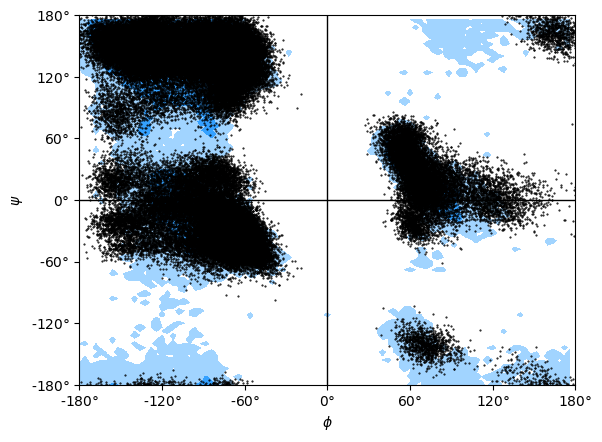

In [18]:
# Ramachandran angles for all the residues in protein. 
# To select a range of frames use .run(startframe,endframe+1)
# The 'protein' selection still refers here to the validation trj
rama = dihedrals.Ramachandran(proteinA).run()
rama.plot(color='black', marker='.', s=1, ref=True)
trj_phipsi_A = rama.results.angles
print(f'Ramachandran angles array shape: {trj_phipsi_A.shape}')

Ramachandran angles array shape: (1000, 88, 2)


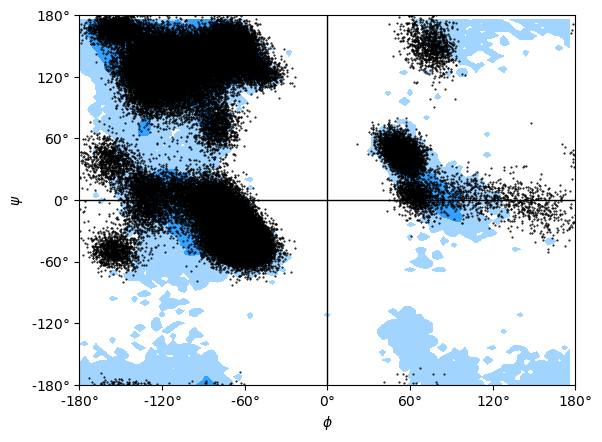

In [19]:
rama = dihedrals.Ramachandran(proteinB).run()
rama.plot(color='black', marker='.', s=1, ref=True)
trj_phipsi_B = rama.results.angles
print(f'Ramachandran angles array shape: {trj_phipsi_B.shape}')

### Conversion of the trajectory into a lists of 4 symbols/frame.

Using simple selection of 4 attraction basins may ignore the actual distributions of angles during the dynamic. The function phipsi_to_basin offers the option to cluster the angles by k-means. We can shift the phi angles in order to obtain a better selection of basins.

In [20]:
def phipsi_to_basin(angles,phi_shift=-120.,cluster=False,n_clusters=4,plot=True):
    
    # Here, we reshape the sequence of frames so that the entire trajectory fits into 
    # a single 2D array for clustering
    shapes = angles.shape
    angles = np.reshape(angles,(shapes[0]*shapes[1],shapes[2]),order='C')

    # Shift in phi angles to obtain clean basins
    for value in angles:
        if value[1]<phi_shift:
            value[1] += 360.    

    init_centroids = np.array([[-100.,150],[-100.,-50.],[100.,-50.],[100.,150.]])
    kmeans = KMeans(n_clusters, 
                    init=init_centroids,
                    random_state=123,
                    algorithm='full').fit(angles)
    centroids = kmeans.cluster_centers_
    # score = kmeans.score(angles)
    
    if cluster:
        preds = kmeans.labels_
    else:
        preds = []
        for phipsi in angles:
            if phipsi[0]<=25. and phipsi[1]>70.:
                preds.append(0)
            elif phipsi[0]<=25. and phipsi[1]<=70.:
                preds.append(1)
            elif phipsi[0]>25. and phipsi[1]<=70.:
                preds.append(2)
            elif phipsi[0]>25. and phipsi[1]>70:
                preds.append(3)
        preds = np.array(preds) 
        
    if plot:
        x = [phipsi[0] for phipsi in angles]
        y = [phipsi[1] for phipsi in angles]

        # The scatter plot has markers colored by the basin cluster
        fig, (ax1) = plt.subplots(1,1)
        fig.set_figheight(5)
        fig.set_figwidth(7)
        fig.suptitle('Ramachandran plot with Basins predictions')
        scatterplot = ax1.scatter(x,y,s=1,c=preds)
        ax1.set_xticklabels(['$-200^{\circ}$','$-150^{\circ}$','$-100^{\circ}$','$-50^{\circ}$',\
                             '$0^{\circ}$','$50^{\circ}$','$100^{\circ}$','$150^{\circ}$'],fontsize=13)
        ax1.set_yticklabels(['$-150^{\circ}$','$-100^{\circ}$','$-50^{\circ}$',\
                             '$0^{\circ}$','$50^{\circ}$','$100^{\circ}$',\
                             '$150^{\circ}$','$200^{\circ}$','$250^{\circ}$'],fontsize=13)
        ax1.set_ylabel("$\psi$",fontsize=14)
        ax1.set_xlabel("$\phi$",fontsize=14)
        ax1.grid()

        # produce a legend with the unique colors from the scatter
        legend = ax1.legend(*scatterplot.legend_elements(),
                            loc="best", title="Classes")
        ax1.add_artist(legend)
        ax1.legend()
                
    basins = np.reshape(preds,(shapes[0],shapes[1]))
    angles = np.reshape(angles,(shapes[0],shapes[1],shapes[2]))            
        
    return angles,basins,centroids

In [21]:
print(trj_phipsi_A.shape)
print(trj_phipsi_B.shape)

(1000, 107, 2)
(1000, 88, 2)


### Validation Basins datasets
First we use as validation set only the first trajectory to obtain a nice image of the clustering

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


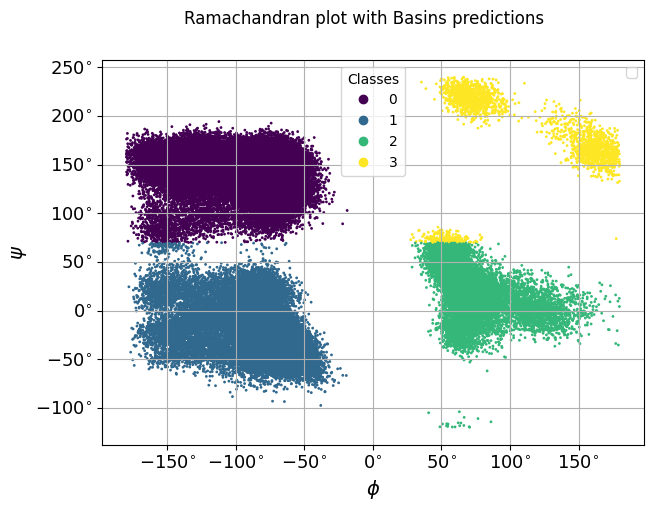

In [22]:
val_angles_A,val_basins_A,val_centroids = phipsi_to_basin(trj_phipsi_A,phi_shift=-120.,
                                                      cluster=False,
                                                      n_clusters=4,
                                                      plot=True)

In [23]:
print(val_basins_A.shape,val_angles_A.shape)

(1000, 107) (1000, 107, 2)


#### Select a validation:test:training split at 20:20:60
In preparation for training we select a more traditional split between validation, test, and training set.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(1000, 88) (1000, 88, 2)


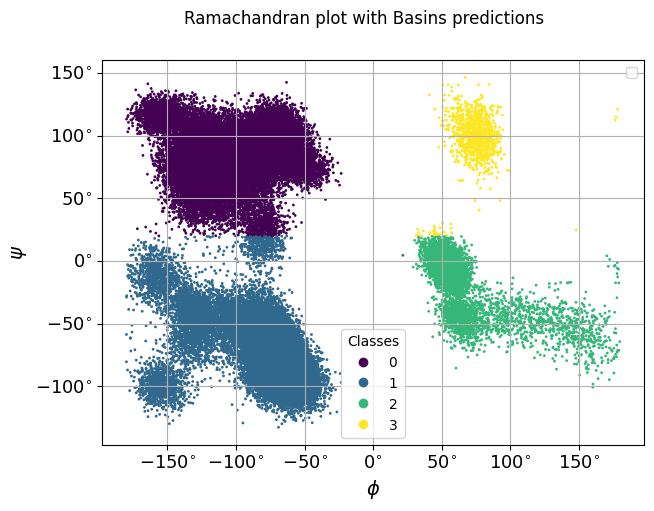

In [24]:
val_angles_B,val_basins_B,val_centroids = phipsi_to_basin(trj_phipsi_B,phi_shift=-120.,
                                                      cluster=False,
                                                      n_clusters=4,
                                                      plot=True)
print(val_basins_B.shape,val_angles_B.shape)

Looks good: we can now use the predictions to convert the trj into an array of frames 
with each frame being an array of 4 symbols, one for each basin of attraction. First and last residues do not have phi-psi angles, so we only have 195 basins for the 197 residues of barnase-barstar complex.

### Dataset serving batches of inputs and targets to the Transformer

Starting from the initial basins dataset, we eliminate consecutive identical  frames and create 3 new datasets each with different padding:
* an input dataset for the encoder with final padding [7 7 7]
* an input dataset for the decoder with initial padding [4] (where 4 is the 'sequence start' signal) and final padding [5 6] (where 5 is the 'sequence end' signal). 
* a target dataset for the transformer with final padding [6 7 7]

The encoder input is the last know frame. The decoder input is the same sequence as the transformer target (the next frame to predict). However they are padded in a different way, as the decoder input must start from a generic 'sequence start' signal (in this case, number 4) to predict the 1st basin of the target, and stop predicting when it encounters a 'sequence end' signal (in this case, number 5). 


In [25]:
# Function to eliminate consecutive identical frames or 
# to skip frames in the basin trajectory
def reduce_basins(basins,ncycles,nskip):

    if ncycles == 0 and nskip > 1:
        trj = np.copy(basins)
        reduced_basins = np.array(trj[0::nskip,:])
    elif ncycles > 0 and nskip == 0:
        red_cycles = ncycles
        trj = np.copy(basins)

        for red_cycle in range(red_cycles):

            first_frame = np.array([trj[0]])
            # print(first_frame.shape,type(first_frame))

            count = 0
            reduced_trj = np.copy(first_frame)
            for i,frame in enumerate(trj):
                frame = np.array([frame])

                if i == 0:
                    previous_frame = first_frame

                if np.array_equal(previous_frame,frame):
                    previous_frame = frame
                    continue
                else:
                    count += 1
                    reduced_trj = np.append(reduced_trj,frame,axis=0)
                    previous_frame = frame

            # print(trj.shape)
            # print(count,reduced_trj.shape)
            trj = reduced_trj

        reduced_basins = trj
    
    return reduced_basins
  

# Function to pre-process basin trajectories for text_to_text_translation
def preprocess_basins(basins_a,basins_b,reduce=True,reduce_cycles=2,skip_frames=0):   
    if reduce:
        basins_a = reduce_basins(basins_a,reduce_cycles,skip_frames)
        basins_b = reduce_basins(basins_b,reduce_cycles,skip_frames)
        
    n_frames = basins_a.shape[0]
    print(basins_a.shape,basins_b.shape)
        
    # Encoder input. This set starts with the first frame and end 
    # with the next to last. The final padding [6,6,6] contains only number 6, 
    # which does not define a 'start', a 'basin', or an 'end'.
    inputs1 = np.zeros((n_frames,198)).astype('int32')
    for i,basin_vec in enumerate(basins_a):
        basin_vec = np.append(basin_vec,np.array([4])) 
        basin_vec = np.append(basin_vec,basins_b[i][:-1])
        basin_vec = np.append(basin_vec,np.array([7,7,7]))
        inputs1[i] = basin_vec

    # Decoder input. This set start with the second frame and ends with the last. 
    # The initial padding [4] shifts the sequence by 1 position forward with 
    # respect to the target sequence. The final padding [5,6] adds an 'end' signal, 
    # and a non descriptive [6].
    inputs2 = np.zeros((n_frames,198)).astype('int32')
    for i,basin_vec in enumerate(basins_a):
        basin_vec = np.concatenate((np.array([5]),basin_vec[1:],np.array([4]),basins_b[i],np.array([6,7]))) 
        inputs2[i] = basin_vec    

    # Transformer target. This set start with the second frame and ends with the last. 
    # It has the same protein sequence of the decoder input, 
    # without an initial 'start' signal [4], and with a final padding [5,6,6] that 
    # contains one 'end' signal [5] and two non-descriptive [6].    
    targets = np.zeros((n_frames,198)).astype('int32')
    for i,basin_vec in enumerate(basins_a):
        basin_vec = np.concatenate((basin_vec[1:],np.array([4]),basins_b[i],np.array([6,7,7]))) 
        targets[i] = basin_vec  
        
    return inputs1,inputs2,targets
    

# Function to format the dataset so that the 1st 2 elements provide inputs 
# and the 3rd element targets. In this case we return a tuple containing a 
# dictionary with two keys for the encoder and decoder inputs, 
# and a target for the transformer
def format_dataset(inputs1,inputs2,targets):
    return ({
            "train1": inputs1,
            "train2": inputs2,
            }, targets)


# Function to make a data.Dataset pipeline to serve batches of basin frames 
# to a Transformer. The number of parallel calls sets the number of cpu cores 
# used for serving data
def dataset_from_basin_trj(basins_a,basins_b,reduce=True,reduce_cycles=2,skip_frames=0,
                           batch_size='All',n_cpu=2,shuffle=True,
                           reshuffle=True,n_fetch=1,cache=False):
       
    inputs1,inputs2,targets = preprocess_basins(basins_a,basins_b,reduce,reduce_cycles,skip_frames)
    dataset = tf.data.Dataset.from_tensor_slices((inputs1,inputs2,targets))
    if batch_size == 'All':
        batch_size = len(targets)        
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset, num_parallel_calls=n_cpu)
    
    # Here we shuffle from a number of elements at least as large as 
    # the number of frames in the dataset and prefetch in memory n_fetch batches 
    # to speed up processing
    
    if shuffle:
        if cache:
            dataset = dataset.shuffle(n_frames+1,reshuffle_each_iteration=reshuffle).prefetch(n_fetch).cache()
        else:
            dataset = dataset.shuffle(n_frames+1,reshuffle_each_iteration=reshuffle).prefetch(n_fetch)
    
    return inputs1,inputs2,targets,dataset

### Validation dataset

In [26]:
val_inputs1,val_inputs2,val_targets,val_dataset = dataset_from_basin_trj(val_basins_A,val_basins_B,
                                                                         reduce=True,
                                                                         reduce_cycles=0,
                                                                         skip_frames=2,
                                                                         batch_size='All',
                                                                         n_cpu=2,
                                                                         n_fetch=1)
val_dataset

(500, 107) (500, 88)


<PrefetchDataset element_spec=({'train1': TensorSpec(shape=(None, 198), dtype=tf.int32, name=None), 'train2': TensorSpec(shape=(None, 198), dtype=tf.int32, name=None)}, TensorSpec(shape=(None, 198), dtype=tf.int32, name=None))>

In [27]:
val_inputs1.shape,val_inputs2.shape,val_targets.shape

((500, 198), (500, 198), (500, 198))

In [28]:
print(f'Number of batches served: {len(val_dataset)}')
print(f'In each batch we have 3 components:')

for inputs, targets in val_dataset.take(1):
    print(f"inputs['train1'] of shape: {inputs['train1'].shape}")
    print(f"inputs['train2'] of shape: {inputs['train2'].shape}")
    print(f"targets of shape: {targets.shape}")

# Alternative syntaxes to iterate the dataset
# it_dataset = iter(val_dataset)
# print(next(it_dataset)) 
'''
for i, batch in enumerate(val_dataset):
    print(batch[0])
    print(batch[1])    
    if i >= 1:
        break
'''

Number of batches served: 1
In each batch we have 3 components:
inputs['train1'] of shape: (500, 198)
inputs['train2'] of shape: (500, 198)
targets of shape: (500, 198)


'\nfor i, batch in enumerate(val_dataset):\n    print(batch[0])\n    print(batch[1])    \n    if i >= 1:\n        break\n'

### New Layer Classes not included in Keras distribution

In [29]:
# Here we modify the original positional embedding layer from Francois Chollet 
# to allow padding with a specific number and embedding based also on 
# res chemical type

class PosEmbedding(Layer):
    def __init__(self, sequence_length, 
                 input_dim, output_dim, pad_num,
                 sequence_as_type, aa_types,
                 target_front_pad, train_end_pad, target_end_pad,
                 train=True, embed_types=True, pad_types=True, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim)
        self.type_embedding = layers.Embedding(
            input_dim=aa_types, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.pad_num = pad_num
        self.sequence_as_type = sequence_as_type
        self.aa_types = aa_types       
        self.target_front_pad = target_front_pad
        self.train_end_pad = train_end_pad
        self.target_end_pad = target_end_pad        
        self.train = train
        self.embed_types = embed_types
        self.pad_types = pad_types         
        

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)

        if self.pad_types:    
            if self.train:
                sequence = tf.concat([self.sequence_as_type,
                                      train_end_pad],-1)
            else:
                sequence = tf.concat([target_front_pad,
                                      self.sequence_as_type,
                                      target_end_pad],-1) 
        else:
            sequence = self.sequence_as_type
            sequence = tf.cast(sequence, dtype="int32")
            
        embedded_type = self.type_embedding(sequence)                     
        
        if self.embed_types:
            return embedded_tokens + embedded_positions + embedded_type
        else:
            return embedded_tokens + embedded_positions     

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, self.pad_num)

    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
            "pad_num": self.pad_num,
            "sequence_as_type": self.sequence_as_type,
            "aa_types": self.aa_types,
            "target_front_pad": self.target_front_pad,
            "train_end_pad": self.train_end_pad,
            "target_end_pad": self.target_end_pad,
            "train": self.train,
            "embed_types": self.embed_types,
            "pad_types": self.pad_types,            
        })
        return config


class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        
        self.attention_scores = None
        self.attention_output = None
        
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
            
        attention_output, attention_scores= self.attention(
            inputs, inputs, attention_mask=mask, return_attention_scores=True)
        
        self.attention_scores = attention_scores
        self.attention_output = attention_output
        
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_attention_scores(self):
        return self.attention_scores,self.attention_output
        
    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
            "attention_scores":self.attention_scores,
            "attention_output":self.attention_output,
        })
        return config
    

class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_scores_1 = None       
        self.attention_output_1 = None
        
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
            "attention_scores1":self.attention_scores_1,
            "attention_output_1":self.attention_output_1,
        })
        return config

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1),
             tf.constant([1, 1], dtype=tf.int32)], axis=0)
        return tf.tile(mask, mult)

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(
                mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)
        attention_output_1,attention_scores_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask, return_attention_scores=True)
        
        self.attention_scores_1 = attention_scores_1
        self.attention_output_1 = attention_output_1
        
        attention_output_1 = self.layernorm_1(inputs + attention_output_1)
        
        attention_output_2 = self.attention_2(
            query=attention_output_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask)
              
        attention_output_2 = self.layernorm_2(
            attention_output_1 + attention_output_2)
        proj_output = self.dense_proj(attention_output_2)
        return self.layernorm_3(attention_output_2 + proj_output)
    
    def get_attention_scores(self):
        return self.attention_scores_1,self.attention_output_1
    

In [30]:
print(len(split_prot_sequence_as_type[1:-1]),len(split_prot_sequence_as_type_A[1:]),len(split_prot_sequence_as_type_B[1:]))
sequence_as_type_A = split_prot_sequence_as_type_A[1:]
sequence_as_type_B = split_prot_sequence_as_type_B[1:]
print(len(sequence_as_type_A),len(sequence_as_type_B))
sequence_as_type_A,




sequence_as_A = []
number_table_to_aa_A = [(i[1],i[0]) for i in aa_to_number_table_A]
for i in sequence_as_type_A:
    for j in number_table_to_aa_A:
        if i ==j[0]:
            sequence_as_A.append(j[1])

sequence_as_B = []
number_table_to_aa_B = [(i[1],i[0]) for i in aa_to_number_table_B]
for i in sequence_as_type_B:
    for j in number_table_to_aa_B:
        if i ==j[0]:
            sequence_as_B.append(j[1])
            

sequence_as_A = seq1("".join(sequence_as_A))
sequence_as_B = seq1("".join(sequence_as_B))

sequence_as_B,sequence_as_A

195 107 88
107 88


('KAVINGEQIRSISDLXQTLKKELALPEYYGENLDALWDALTGWVEYPLVLEWRQFEQSKQLTENGAESVLQVFREAKAEGADITIILS',
 'INTFDGVADYLQTYXKLPDNYITKSEAQALGWVASKGNLADVAPGKSIGGDIFSNREGKLPGKSGRTWREADINYTSGFRNSDRILYSSDWLIYKTTDXYQTFTKIR')

### Transformer architecture 

In [31]:
# Text-to-text transformer using dataset pipeline
keras.backend.clear_session()

if "transformer" in globals() or "transformer" in locals():
    del transformer
       
pad_length = 3
train_end_pad = [7,7,7]
target_front_pad = [5]
target_end_pad = [6,7]


sequence_length = len(sequence_as_type_AB)
padded_sequence_length_AB = sequence_length + pad_length

print(padded_sequence_length_AB)

embed_dim = 32
pad_num = 7
classes = pad_num + 1
vocab_size = 8
num_heads = 4
dense_dim = 64
aa_types = 22

# Unflag the following two lines if using multiple GPU's and indent the network definition 
# strategy = tf.distribute.MirroredStrategy()
# with strategy.scope():

# ######################### Network definition start ######################

encoder_inputs = keras.Input(shape=(None,), dtype="int32", name='train1')
x = PosEmbedding(padded_sequence_length_AB, vocab_size, embed_dim, pad_num, 
                  sequence_as_type_AB, aa_types, 
                  train_end_pad, target_front_pad, target_end_pad, 
                  train=True, embed_types=True, pad_types=True,
                  name='EncoderEmbedding')(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, dense_dim, 
                                     num_heads, name='Encoder')(x)    

decoder_inputs = keras.Input(shape=(None,), dtype="int32", name='train2')   

print(x.shape)

x = PosEmbedding(padded_sequence_length_AB, vocab_size, embed_dim, pad_num, 
                  sequence_as_type_AB, aa_types, 
                  train_end_pad, target_front_pad, target_end_pad, 
                  train=False, embed_types=True, pad_types=True, 
                  name='DecoderEmbedding')(decoder_inputs) 

print(x.shape,encoder_outputs.shape)

x = TransformerDecoder(embed_dim, dense_dim, 
                       num_heads, name='Decoder')(x, encoder_outputs)
print(x.shape)

x = Dropout(0.5, name='Dropout')(x)
decoder_outputs = Dense(classes, activation="softmax", name='Softmax')(x)

transformer = keras.Model([encoder_inputs,decoder_inputs], decoder_outputs)
transformer.compile(optimizer="rmsprop", 
                    loss="sparse_categorical_crossentropy", 
                    metrics=["accuracy"])

# ######################### Network definition end ####################### 
    
transformer.summary()

198
(None, 198, 32)
(None, 198, 32) (None, 198, 32)
(None, 198, 32)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 train1 (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 train2 (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 EncoderEmbedding (PosEmbedding  (None, 198, 32)     7296        ['train1[0][0]']                 
 )                                                                                                
                                                                                                  
 DecoderEmbedding (PosEmbe

### Training loop.

Here we iterate for 1 epochs trought all the trajectories in the ensemble starting from trajectory index=2, further refining the transformer model. This is what we consider a 'sub-epoch'. In each sub-epoch the training set is the current trajectory from the loop, while the validation set is always the trajectory with index=0. The number of batches served in each sub-epoch is determined by the number chosen for the execution of the dataset_from_basin_trj function. 

The number of true 'epochs' is the number of times we iterate over the entire ensemble. Currently, this loop saves memory, but unfortunately recalculates the rama angles in each epoch. It does not seem to slow down the fit, but in future we may put everything in memory from the start.

If the number of batches in 'dataset_from_basin_trj' is set to 'All', then the entire trajectory is served as a single batch, and the number of 'epochs' corresponds to the traditional definition of 'epoch' for the entire ensemble of trajectories.

In [32]:
# We fit for 10 epochs of 300 subepochs. Each subepoch is a trajectory 
# served as batches of 'batch_size' frames

train_acc = []
val_acc = []

train_loss = []
val_loss = []

sub_epoch = 1
epochs = 10

trj_ind_list = list(range(0,n_trj))
print(n_trj)

for epoch in range(epochs):
    
    # In every epoch we reshuffle the trajectories
    trj_ind_list_shuffled = random.sample(trj_ind_list,len(trj_ind_list))
    print(f'Shuffled list of trajectories:')
    print(trj_ind_list_shuffled,'\n')
    
    for i in range(len(trj_ind_list_shuffled)):
    # for i,trajectory in enumerate(adk_trans.trajectories[2:]):
        trj_ind = trj_ind_list_shuffled[i]
        # the universe is updated with the next trajectory from the ensemble
        u = mda.Universe(ppi_topology, ppi_trajectories[trj_ind])
        n_frames = len(u.trajectory)
    #     print(f'There are {n_frames} frames in the trajectory')
        proteinA = u_val.select_atoms('resid 1:108')
        ramaA = dihedrals.Ramachandran(proteinA).run()
        trj_phipsiA = ramaA.results.angles
        _,basinsA,_ = phipsi_to_basin(trj_phipsiA,phi_shift=-120.,
                                     cluster=False,
                                     n_clusters=4,
                                     plot=False)
        
        proteinB = u_val.select_atoms('resid 109:197')
        ramaB = dihedrals.Ramachandran(proteinB).run()
        trj_phipsiB = ramaB.results.angles
        _,basinsB,_ = phipsi_to_basin(trj_phipsiB,phi_shift=-120.,
                                     cluster=False,
                                     n_clusters=4,
                                     plot=False)
        
 
        _,_,_,dataset = dataset_from_basin_trj(basinsA,basinsB,
                                               reduce=True,
                                               reduce_cycles=0,
                                               skip_frames=6,
                                               batch_size='All',
                                               n_cpu=2,
                                               n_fetch=1)      

    # Here we train the network by fitting predictions to targets for 100 epochs,
    # and we plot the loss over the epochs
        print(f'Epoch {epoch+1} Trajectory {i+1} [Ensemble Trajectory {trj_ind}]')
        history_transformer = transformer.fit(dataset,
                                              validation_data=val_dataset,
                                              epochs=sub_epoch)

        train_acc.append(history_transformer.history["accuracy"])
        val_acc.append(history_transformer.history["val_accuracy"])
        train_loss.append(history_transformer.history["loss"])
        val_loss.append(history_transformer.history["val_loss"])       

300
Shuffled list of trajectories:
[225, 168, 165, 143, 282, 215, 217, 15, 266, 294, 106, 224, 48, 86, 264, 25, 292, 19, 68, 75, 125, 251, 296, 18, 203, 197, 267, 101, 293, 189, 120, 170, 98, 102, 255, 253, 113, 157, 13, 274, 236, 17, 211, 66, 88, 191, 252, 268, 93, 46, 91, 259, 243, 194, 260, 184, 77, 238, 265, 171, 187, 231, 180, 85, 233, 214, 28, 142, 284, 258, 169, 245, 156, 152, 59, 200, 181, 278, 148, 5, 240, 99, 237, 70, 105, 273, 219, 21, 83, 277, 126, 178, 100, 144, 61, 298, 269, 133, 190, 230, 218, 23, 14, 39, 104, 130, 45, 34, 140, 145, 186, 213, 44, 60, 111, 222, 124, 35, 122, 134, 137, 136, 291, 108, 205, 288, 95, 16, 114, 185, 131, 40, 118, 247, 192, 202, 249, 286, 193, 195, 150, 50, 207, 67, 2, 112, 262, 129, 74, 147, 26, 29, 257, 49, 261, 9, 71, 138, 20, 96, 12, 22, 188, 55, 242, 290, 159, 4, 164, 183, 206, 241, 7, 110, 182, 89, 80, 227, 97, 208, 276, 84, 198, 109, 119, 246, 244, 72, 155, 57, 151, 212, 163, 81, 281, 235, 229, 158, 146, 54, 27, 179, 173, 275, 239, 107, 1

1/1 [==============================] - 0s 145ms/step - loss: 0.0889 - accuracy: 0.9902 - val_loss: 0.0306 - val_accuracy: 0.9944
(167, 107) (167, 88)
Epoch 1 Trajectory 36 [Ensemble Trajectory 253]
1/1 [==============================] - 0s 146ms/step - loss: 0.0854 - accuracy: 0.9895 - val_loss: 0.0312 - val_accuracy: 0.9947
(167, 107) (167, 88)
Epoch 1 Trajectory 37 [Ensemble Trajectory 113]
1/1 [==============================] - 0s 140ms/step - loss: 0.0837 - accuracy: 0.9909 - val_loss: 0.0287 - val_accuracy: 0.9944
(167, 107) (167, 88)
Epoch 1 Trajectory 38 [Ensemble Trajectory 157]
1/1 [==============================] - 0s 144ms/step - loss: 0.0791 - accuracy: 0.9907 - val_loss: 0.0293 - val_accuracy: 0.9947
(167, 107) (167, 88)
Epoch 1 Trajectory 39 [Ensemble Trajectory 13]
1/1 [==============================] - 0s 142ms/step - loss: 0.0750 - accuracy: 0.9922 - val_loss: 0.0270 - val_accuracy: 0.9944
(167, 107) (167, 88)
Epoch 1 Trajectory 40 [Ensemble Trajectory 274]
1/1 [======

(167, 107) (167, 88)
Epoch 1 Trajectory 77 [Ensemble Trajectory 181]
1/1 [==============================] - 0s 137ms/step - loss: 0.0337 - accuracy: 0.9942 - val_loss: 0.0183 - val_accuracy: 0.9944
(167, 107) (167, 88)
Epoch 1 Trajectory 78 [Ensemble Trajectory 278]
1/1 [==============================] - 0s 145ms/step - loss: 0.0344 - accuracy: 0.9934 - val_loss: 0.0214 - val_accuracy: 0.9947
(167, 107) (167, 88)
Epoch 1 Trajectory 79 [Ensemble Trajectory 148]
1/1 [==============================] - 0s 143ms/step - loss: 0.0359 - accuracy: 0.9937 - val_loss: 0.0189 - val_accuracy: 0.9944
(167, 107) (167, 88)
Epoch 1 Trajectory 80 [Ensemble Trajectory 5]
1/1 [==============================] - 0s 145ms/step - loss: 0.0355 - accuracy: 0.9934 - val_loss: 0.0202 - val_accuracy: 0.9947
(167, 107) (167, 88)
Epoch 1 Trajectory 81 [Ensemble Trajectory 240]
1/1 [==============================] - 0s 135ms/step - loss: 0.0339 - accuracy: 0.9942 - val_loss: 0.0178 - val_accuracy: 0.9944
(167, 107) (

1/1 [==============================] - 0s 138ms/step - loss: 0.0195 - accuracy: 0.9939 - val_loss: 0.0158 - val_accuracy: 0.9947
(167, 107) (167, 88)
Epoch 1 Trajectory 160 [Ensemble Trajectory 96]
1/1 [==============================] - 0s 144ms/step - loss: 0.0192 - accuracy: 0.9946 - val_loss: 0.0153 - val_accuracy: 0.9947
(167, 107) (167, 88)
Epoch 1 Trajectory 161 [Ensemble Trajectory 12]
1/1 [==============================] - 0s 144ms/step - loss: 0.0195 - accuracy: 0.9940 - val_loss: 0.0161 - val_accuracy: 0.9947
(167, 107) (167, 88)
Epoch 1 Trajectory 162 [Ensemble Trajectory 22]
1/1 [==============================] - 0s 144ms/step - loss: 0.0196 - accuracy: 0.9947 - val_loss: 0.0158 - val_accuracy: 0.9944
(167, 107) (167, 88)
Epoch 1 Trajectory 163 [Ensemble Trajectory 188]
1/1 [==============================] - 0s 138ms/step - loss: 0.0205 - accuracy: 0.9936 - val_loss: 0.0178 - val_accuracy: 0.9947
(167, 107) (167, 88)
Epoch 1 Trajectory 164 [Ensemble Trajectory 55]
1/1 [====

1/1 [==============================] - 0s 137ms/step - loss: 0.0177 - accuracy: 0.9948 - val_loss: 0.0158 - val_accuracy: 0.9944
(167, 107) (167, 88)
Epoch 1 Trajectory 242 [Ensemble Trajectory 289]
1/1 [==============================] - 0s 137ms/step - loss: 0.0172 - accuracy: 0.9940 - val_loss: 0.0164 - val_accuracy: 0.9947
(167, 107) (167, 88)
Epoch 1 Trajectory 243 [Ensemble Trajectory 174]
1/1 [==============================] - 0s 138ms/step - loss: 0.0172 - accuracy: 0.9946 - val_loss: 0.0158 - val_accuracy: 0.9944
(167, 107) (167, 88)
Epoch 1 Trajectory 244 [Ensemble Trajectory 176]
1/1 [==============================] - 0s 146ms/step - loss: 0.0173 - accuracy: 0.9938 - val_loss: 0.0165 - val_accuracy: 0.9947
(167, 107) (167, 88)
Epoch 1 Trajectory 245 [Ensemble Trajectory 287]
1/1 [==============================] - 0s 145ms/step - loss: 0.0179 - accuracy: 0.9946 - val_loss: 0.0161 - val_accuracy: 0.9944
(167, 107) (167, 88)
Epoch 1 Trajectory 246 [Ensemble Trajectory 69]
1/1 [=

1/1 [==============================] - 0s 139ms/step - loss: 0.0166 - accuracy: 0.9948 - val_loss: 0.0158 - val_accuracy: 0.9944
(167, 107) (167, 88)
Epoch 2 Trajectory 17 [Ensemble Trajectory 38]
1/1 [==============================] - 0s 146ms/step - loss: 0.0165 - accuracy: 0.9945 - val_loss: 0.0160 - val_accuracy: 0.9947
(167, 107) (167, 88)
Epoch 2 Trajectory 18 [Ensemble Trajectory 218]
1/1 [==============================] - 0s 144ms/step - loss: 0.0160 - accuracy: 0.9946 - val_loss: 0.0158 - val_accuracy: 0.9947
(167, 107) (167, 88)
Epoch 2 Trajectory 19 [Ensemble Trajectory 94]
1/1 [==============================] - 0s 145ms/step - loss: 0.0159 - accuracy: 0.9947 - val_loss: 0.0159 - val_accuracy: 0.9947
(167, 107) (167, 88)
Epoch 2 Trajectory 20 [Ensemble Trajectory 164]
1/1 [==============================] - 0s 138ms/step - loss: 0.0165 - accuracy: 0.9946 - val_loss: 0.0159 - val_accuracy: 0.9947
(167, 107) (167, 88)
Epoch 2 Trajectory 21 [Ensemble Trajectory 213]
1/1 [=======

(167, 107) (167, 88)
Epoch 2 Trajectory 58 [Ensemble Trajectory 210]
1/1 [==============================] - 0s 145ms/step - loss: 0.0162 - accuracy: 0.9948 - val_loss: 0.0159 - val_accuracy: 0.9947
(167, 107) (167, 88)
Epoch 2 Trajectory 59 [Ensemble Trajectory 233]
1/1 [==============================] - 0s 144ms/step - loss: 0.0162 - accuracy: 0.9941 - val_loss: 0.0163 - val_accuracy: 0.9947
(167, 107) (167, 88)
Epoch 2 Trajectory 60 [Ensemble Trajectory 13]
1/1 [==============================] - 0s 143ms/step - loss: 0.0165 - accuracy: 0.9948 - val_loss: 0.0163 - val_accuracy: 0.9947
(167, 107) (167, 88)
Epoch 2 Trajectory 61 [Ensemble Trajectory 244]
1/1 [==============================] - 0s 144ms/step - loss: 0.0164 - accuracy: 0.9944 - val_loss: 0.0165 - val_accuracy: 0.9947
(167, 107) (167, 88)
Epoch 2 Trajectory 62 [Ensemble Trajectory 120]
1/1 [==============================] - 0s 144ms/step - loss: 0.0164 - accuracy: 0.9948 - val_loss: 0.0160 - val_accuracy: 0.9947
(167, 107) 

1/1 [==============================] - 0s 144ms/step - loss: 0.0157 - accuracy: 0.9948 - val_loss: 0.0159 - val_accuracy: 0.9947
(167, 107) (167, 88)
Epoch 2 Trajectory 141 [Ensemble Trajectory 137]
1/1 [==============================] - 0s 146ms/step - loss: 0.0157 - accuracy: 0.9948 - val_loss: 0.0160 - val_accuracy: 0.9947
(167, 107) (167, 88)
Epoch 2 Trajectory 142 [Ensemble Trajectory 11]
1/1 [==============================] - 0s 145ms/step - loss: 0.0158 - accuracy: 0.9947 - val_loss: 0.0160 - val_accuracy: 0.9947
(167, 107) (167, 88)
Epoch 2 Trajectory 143 [Ensemble Trajectory 83]
1/1 [==============================] - 0s 144ms/step - loss: 0.0154 - accuracy: 0.9946 - val_loss: 0.0165 - val_accuracy: 0.9947
(167, 107) (167, 88)
Epoch 2 Trajectory 144 [Ensemble Trajectory 228]
1/1 [==============================] - 0s 145ms/step - loss: 0.0160 - accuracy: 0.9947 - val_loss: 0.0163 - val_accuracy: 0.9947
(167, 107) (167, 88)
Epoch 2 Trajectory 145 [Ensemble Trajectory 261]
1/1 [==

1/1 [==============================] - 0s 142ms/step - loss: 0.0163 - accuracy: 0.9942 - val_loss: 0.0163 - val_accuracy: 0.9947
(167, 107) (167, 88)
Epoch 2 Trajectory 223 [Ensemble Trajectory 131]
1/1 [==============================] - 0s 145ms/step - loss: 0.0157 - accuracy: 0.9948 - val_loss: 0.0159 - val_accuracy: 0.9947
(167, 107) (167, 88)
Epoch 2 Trajectory 224 [Ensemble Trajectory 144]
1/1 [==============================] - 0s 147ms/step - loss: 0.0149 - accuracy: 0.9945 - val_loss: 0.0160 - val_accuracy: 0.9947
(167, 107) (167, 88)
Epoch 2 Trajectory 225 [Ensemble Trajectory 63]
1/1 [==============================] - 0s 143ms/step - loss: 0.0153 - accuracy: 0.9947 - val_loss: 0.0158 - val_accuracy: 0.9947
(167, 107) (167, 88)
Epoch 2 Trajectory 226 [Ensemble Trajectory 66]
1/1 [==============================] - 0s 145ms/step - loss: 0.0153 - accuracy: 0.9944 - val_loss: 0.0160 - val_accuracy: 0.9947
(167, 107) (167, 88)
Epoch 2 Trajectory 227 [Ensemble Trajectory 12]
1/1 [===

(167, 107) (167, 88)
Epoch 3 Trajectory 1 [Ensemble Trajectory 223]
1/1 [==============================] - 0s 144ms/step - loss: 0.0157 - accuracy: 0.9945 - val_loss: 0.0172 - val_accuracy: 0.9947
(167, 107) (167, 88)
Epoch 3 Trajectory 2 [Ensemble Trajectory 192]
1/1 [==============================] - 0s 139ms/step - loss: 0.0159 - accuracy: 0.9948 - val_loss: 0.0162 - val_accuracy: 0.9944
(167, 107) (167, 88)
Epoch 3 Trajectory 3 [Ensemble Trajectory 152]
1/1 [==============================] - 0s 145ms/step - loss: 0.0152 - accuracy: 0.9940 - val_loss: 0.0163 - val_accuracy: 0.9946
(167, 107) (167, 88)
Epoch 3 Trajectory 4 [Ensemble Trajectory 166]
1/1 [==============================] - 0s 142ms/step - loss: 0.0149 - accuracy: 0.9948 - val_loss: 0.0159 - val_accuracy: 0.9944
(167, 107) (167, 88)
Epoch 3 Trajectory 5 [Ensemble Trajectory 40]
1/1 [==============================] - 0s 142ms/step - loss: 0.0146 - accuracy: 0.9946 - val_loss: 0.0159 - val_accuracy: 0.9946
(167, 107) (167,

(167, 107) (167, 88)
Epoch 3 Trajectory 84 [Ensemble Trajectory 241]
1/1 [==============================] - 0s 145ms/step - loss: 0.0144 - accuracy: 0.9950 - val_loss: 0.0162 - val_accuracy: 0.9947
(167, 107) (167, 88)
Epoch 3 Trajectory 85 [Ensemble Trajectory 144]
1/1 [==============================] - 0s 136ms/step - loss: 0.0151 - accuracy: 0.9948 - val_loss: 0.0157 - val_accuracy: 0.9947
(167, 107) (167, 88)
Epoch 3 Trajectory 86 [Ensemble Trajectory 287]
1/1 [==============================] - 0s 136ms/step - loss: 0.0143 - accuracy: 0.9949 - val_loss: 0.0160 - val_accuracy: 0.9947
(167, 107) (167, 88)
Epoch 3 Trajectory 87 [Ensemble Trajectory 125]
1/1 [==============================] - 0s 145ms/step - loss: 0.0141 - accuracy: 0.9948 - val_loss: 0.0156 - val_accuracy: 0.9947
(167, 107) (167, 88)
Epoch 3 Trajectory 88 [Ensemble Trajectory 182]
1/1 [==============================] - 0s 135ms/step - loss: 0.0141 - accuracy: 0.9950 - val_loss: 0.0159 - val_accuracy: 0.9947
(167, 107)

1/1 [==============================] - 0s 145ms/step - loss: 0.0157 - accuracy: 0.9942 - val_loss: 0.0179 - val_accuracy: 0.9947
(167, 107) (167, 88)
Epoch 3 Trajectory 126 [Ensemble Trajectory 167]
1/1 [==============================] - 0s 146ms/step - loss: 0.0167 - accuracy: 0.9947 - val_loss: 0.0158 - val_accuracy: 0.9947
(167, 107) (167, 88)
Epoch 3 Trajectory 127 [Ensemble Trajectory 174]
1/1 [==============================] - 0s 146ms/step - loss: 0.0147 - accuracy: 0.9947 - val_loss: 0.0155 - val_accuracy: 0.9947
(167, 107) (167, 88)
Epoch 3 Trajectory 128 [Ensemble Trajectory 36]
1/1 [==============================] - 0s 146ms/step - loss: 0.0141 - accuracy: 0.9949 - val_loss: 0.0154 - val_accuracy: 0.9947
(167, 107) (167, 88)
Epoch 3 Trajectory 129 [Ensemble Trajectory 99]
1/1 [==============================] - 0s 138ms/step - loss: 0.0140 - accuracy: 0.9948 - val_loss: 0.0153 - val_accuracy: 0.9947
(167, 107) (167, 88)
Epoch 3 Trajectory 130 [Ensemble Trajectory 2]
1/1 [====

1/1 [==============================] - 0s 137ms/step - loss: 0.0123 - accuracy: 0.9958 - val_loss: 0.0140 - val_accuracy: 0.9956
(167, 107) (167, 88)
Epoch 3 Trajectory 208 [Ensemble Trajectory 140]
1/1 [==============================] - 0s 145ms/step - loss: 0.0127 - accuracy: 0.9954 - val_loss: 0.0139 - val_accuracy: 0.9956
(167, 107) (167, 88)
Epoch 3 Trajectory 209 [Ensemble Trajectory 35]
1/1 [==============================] - 0s 137ms/step - loss: 0.0122 - accuracy: 0.9957 - val_loss: 0.0138 - val_accuracy: 0.9957
(167, 107) (167, 88)
Epoch 3 Trajectory 210 [Ensemble Trajectory 232]
1/1 [==============================] - 0s 139ms/step - loss: 0.0122 - accuracy: 0.9956 - val_loss: 0.0140 - val_accuracy: 0.9957
(167, 107) (167, 88)
Epoch 3 Trajectory 211 [Ensemble Trajectory 67]
1/1 [==============================] - 0s 136ms/step - loss: 0.0123 - accuracy: 0.9958 - val_loss: 0.0138 - val_accuracy: 0.9956
(167, 107) (167, 88)
Epoch 3 Trajectory 212 [Ensemble Trajectory 21]
1/1 [===

1/1 [==============================] - 0s 137ms/step - loss: 0.0124 - accuracy: 0.9957 - val_loss: 0.0138 - val_accuracy: 0.9957
(167, 107) (167, 88)
Epoch 3 Trajectory 290 [Ensemble Trajectory 68]
1/1 [==============================] - 0s 138ms/step - loss: 0.0118 - accuracy: 0.9958 - val_loss: 0.0136 - val_accuracy: 0.9957
(167, 107) (167, 88)
Epoch 3 Trajectory 291 [Ensemble Trajectory 199]
1/1 [==============================] - 0s 135ms/step - loss: 0.0114 - accuracy: 0.9957 - val_loss: 0.0135 - val_accuracy: 0.9957
(167, 107) (167, 88)
Epoch 3 Trajectory 292 [Ensemble Trajectory 44]
1/1 [==============================] - 0s 145ms/step - loss: 0.0114 - accuracy: 0.9959 - val_loss: 0.0135 - val_accuracy: 0.9956
(167, 107) (167, 88)
Epoch 3 Trajectory 293 [Ensemble Trajectory 92]
1/1 [==============================] - 0s 142ms/step - loss: 0.0112 - accuracy: 0.9957 - val_loss: 0.0135 - val_accuracy: 0.9958
(167, 107) (167, 88)
Epoch 3 Trajectory 294 [Ensemble Trajectory 221]
1/1 [===

(167, 107) (167, 88)
Epoch 4 Trajectory 65 [Ensemble Trajectory 122]
1/1 [==============================] - 0s 144ms/step - loss: 0.0108 - accuracy: 0.9957 - val_loss: 0.0135 - val_accuracy: 0.9959
(167, 107) (167, 88)
Epoch 4 Trajectory 66 [Ensemble Trajectory 156]
1/1 [==============================] - 0s 144ms/step - loss: 0.0109 - accuracy: 0.9960 - val_loss: 0.0134 - val_accuracy: 0.9958
(167, 107) (167, 88)
Epoch 4 Trajectory 67 [Ensemble Trajectory 71]
1/1 [==============================] - 0s 137ms/step - loss: 0.0106 - accuracy: 0.9959 - val_loss: 0.0134 - val_accuracy: 0.9958
(167, 107) (167, 88)
Epoch 4 Trajectory 68 [Ensemble Trajectory 236]
1/1 [==============================] - 0s 142ms/step - loss: 0.0106 - accuracy: 0.9960 - val_loss: 0.0134 - val_accuracy: 0.9958
(167, 107) (167, 88)
Epoch 4 Trajectory 69 [Ensemble Trajectory 214]
1/1 [==============================] - 0s 145ms/step - loss: 0.0105 - accuracy: 0.9965 - val_loss: 0.0133 - val_accuracy: 0.9958
(167, 107) 

1/1 [==============================] - 0s 139ms/step - loss: 0.0119 - accuracy: 0.9958 - val_loss: 0.0141 - val_accuracy: 0.9957
(167, 107) (167, 88)
Epoch 4 Trajectory 148 [Ensemble Trajectory 160]
1/1 [==============================] - 0s 142ms/step - loss: 0.0116 - accuracy: 0.9959 - val_loss: 0.0138 - val_accuracy: 0.9957
(167, 107) (167, 88)
Epoch 4 Trajectory 149 [Ensemble Trajectory 7]
1/1 [==============================] - 0s 145ms/step - loss: 0.0112 - accuracy: 0.9958 - val_loss: 0.0134 - val_accuracy: 0.9957
(167, 107) (167, 88)
Epoch 4 Trajectory 150 [Ensemble Trajectory 279]
1/1 [==============================] - 0s 146ms/step - loss: 0.0106 - accuracy: 0.9957 - val_loss: 0.0133 - val_accuracy: 0.9957
(167, 107) (167, 88)
Epoch 4 Trajectory 151 [Ensemble Trajectory 130]
1/1 [==============================] - 0s 144ms/step - loss: 0.0107 - accuracy: 0.9959 - val_loss: 0.0132 - val_accuracy: 0.9960
(167, 107) (167, 88)
Epoch 4 Trajectory 152 [Ensemble Trajectory 259]
1/1 [==

1/1 [==============================] - 0s 144ms/step - loss: 0.0098 - accuracy: 0.9962 - val_loss: 0.0134 - val_accuracy: 0.9959
(167, 107) (167, 88)
Epoch 4 Trajectory 230 [Ensemble Trajectory 189]
1/1 [==============================] - 0s 138ms/step - loss: 0.0094 - accuracy: 0.9963 - val_loss: 0.0135 - val_accuracy: 0.9959
(167, 107) (167, 88)
Epoch 4 Trajectory 231 [Ensemble Trajectory 208]
1/1 [==============================] - 0s 137ms/step - loss: 0.0099 - accuracy: 0.9959 - val_loss: 0.0135 - val_accuracy: 0.9958
(167, 107) (167, 88)
Epoch 4 Trajectory 232 [Ensemble Trajectory 138]
1/1 [==============================] - 0s 146ms/step - loss: 0.0097 - accuracy: 0.9962 - val_loss: 0.0135 - val_accuracy: 0.9959
(167, 107) (167, 88)
Epoch 4 Trajectory 233 [Ensemble Trajectory 125]
1/1 [==============================] - 0s 136ms/step - loss: 0.0103 - accuracy: 0.9962 - val_loss: 0.0138 - val_accuracy: 0.9957
(167, 107) (167, 88)
Epoch 4 Trajectory 234 [Ensemble Trajectory 118]
1/1 [

1/1 [==============================] - 0s 137ms/step - loss: 0.0094 - accuracy: 0.9962 - val_loss: 0.0135 - val_accuracy: 0.9957
(167, 107) (167, 88)
Epoch 5 Trajectory 5 [Ensemble Trajectory 145]
1/1 [==============================] - 0s 139ms/step - loss: 0.0096 - accuracy: 0.9958 - val_loss: 0.0141 - val_accuracy: 0.9959
(167, 107) (167, 88)
Epoch 5 Trajectory 6 [Ensemble Trajectory 71]
1/1 [==============================] - 0s 145ms/step - loss: 0.0106 - accuracy: 0.9962 - val_loss: 0.0136 - val_accuracy: 0.9957
(167, 107) (167, 88)
Epoch 5 Trajectory 7 [Ensemble Trajectory 74]
1/1 [==============================] - 0s 145ms/step - loss: 0.0096 - accuracy: 0.9958 - val_loss: 0.0138 - val_accuracy: 0.9960
(167, 107) (167, 88)
Epoch 5 Trajectory 8 [Ensemble Trajectory 93]
1/1 [==============================] - 0s 134ms/step - loss: 0.0098 - accuracy: 0.9962 - val_loss: 0.0133 - val_accuracy: 0.9958
(167, 107) (167, 88)
Epoch 5 Trajectory 9 [Ensemble Trajectory 144]
1/1 [=============

(167, 107) (167, 88)
Epoch 5 Trajectory 46 [Ensemble Trajectory 13]
1/1 [==============================] - 0s 142ms/step - loss: 0.0099 - accuracy: 0.9963 - val_loss: 0.0139 - val_accuracy: 0.9957
(167, 107) (167, 88)
Epoch 5 Trajectory 47 [Ensemble Trajectory 95]
1/1 [==============================] - 0s 145ms/step - loss: 0.0099 - accuracy: 0.9956 - val_loss: 0.0146 - val_accuracy: 0.9960
(167, 107) (167, 88)
Epoch 5 Trajectory 48 [Ensemble Trajectory 167]
1/1 [==============================] - 0s 140ms/step - loss: 0.0101 - accuracy: 0.9963 - val_loss: 0.0132 - val_accuracy: 0.9958
(167, 107) (167, 88)
Epoch 5 Trajectory 49 [Ensemble Trajectory 204]
1/1 [==============================] - 0s 139ms/step - loss: 0.0091 - accuracy: 0.9958 - val_loss: 0.0133 - val_accuracy: 0.9960
(167, 107) (167, 88)
Epoch 5 Trajectory 50 [Ensemble Trajectory 236]
1/1 [==============================] - 0s 144ms/step - loss: 0.0088 - accuracy: 0.9964 - val_loss: 0.0131 - val_accuracy: 0.9960
(167, 107) (

1/1 [==============================] - 0s 147ms/step - loss: 0.0089 - accuracy: 0.9964 - val_loss: 0.0130 - val_accuracy: 0.9975
(167, 107) (167, 88)
Epoch 5 Trajectory 129 [Ensemble Trajectory 241]
1/1 [==============================] - 0s 145ms/step - loss: 0.0087 - accuracy: 0.9967 - val_loss: 0.0137 - val_accuracy: 0.9959
(167, 107) (167, 88)
Epoch 5 Trajectory 130 [Ensemble Trajectory 29]
1/1 [==============================] - 0s 140ms/step - loss: 0.0092 - accuracy: 0.9964 - val_loss: 0.0146 - val_accuracy: 0.9958
(167, 107) (167, 88)
Epoch 5 Trajectory 131 [Ensemble Trajectory 298]
1/1 [==============================] - 0s 145ms/step - loss: 0.0110 - accuracy: 0.9962 - val_loss: 0.0135 - val_accuracy: 0.9959
(167, 107) (167, 88)
Epoch 5 Trajectory 132 [Ensemble Trajectory 238]
1/1 [==============================] - 0s 144ms/step - loss: 0.0093 - accuracy: 0.9963 - val_loss: 0.0133 - val_accuracy: 0.9963
(167, 107) (167, 88)
Epoch 5 Trajectory 133 [Ensemble Trajectory 59]
1/1 [==

1/1 [==============================] - 0s 144ms/step - loss: 0.0132 - accuracy: 0.9953 - val_loss: 0.0139 - val_accuracy: 0.9960
(167, 107) (167, 88)
Epoch 5 Trajectory 211 [Ensemble Trajectory 5]
1/1 [==============================] - 0s 144ms/step - loss: 0.0106 - accuracy: 0.9964 - val_loss: 0.0135 - val_accuracy: 0.9960
(167, 107) (167, 88)
Epoch 5 Trajectory 212 [Ensemble Trajectory 274]
1/1 [==============================] - 0s 136ms/step - loss: 0.0095 - accuracy: 0.9964 - val_loss: 0.0132 - val_accuracy: 0.9960
(167, 107) (167, 88)
Epoch 5 Trajectory 213 [Ensemble Trajectory 180]
1/1 [==============================] - 0s 142ms/step - loss: 0.0094 - accuracy: 0.9966 - val_loss: 0.0132 - val_accuracy: 0.9961
(167, 107) (167, 88)
Epoch 5 Trajectory 214 [Ensemble Trajectory 97]
1/1 [==============================] - 0s 138ms/step - loss: 0.0090 - accuracy: 0.9964 - val_loss: 0.0131 - val_accuracy: 0.9960
(167, 107) (167, 88)
Epoch 5 Trajectory 215 [Ensemble Trajectory 79]
1/1 [====

1/1 [==============================] - 0s 145ms/step - loss: 0.0154 - accuracy: 0.9953 - val_loss: 0.0135 - val_accuracy: 0.9960
(167, 107) (167, 88)
Epoch 5 Trajectory 293 [Ensemble Trajectory 289]
1/1 [==============================] - 0s 142ms/step - loss: 0.0103 - accuracy: 0.9959 - val_loss: 0.0134 - val_accuracy: 0.9960
(167, 107) (167, 88)
Epoch 5 Trajectory 294 [Ensemble Trajectory 96]
1/1 [==============================] - 0s 144ms/step - loss: 0.0092 - accuracy: 0.9964 - val_loss: 0.0131 - val_accuracy: 0.9960
(167, 107) (167, 88)
Epoch 5 Trajectory 295 [Ensemble Trajectory 137]
1/1 [==============================] - 0s 146ms/step - loss: 0.0088 - accuracy: 0.9964 - val_loss: 0.0130 - val_accuracy: 0.9960
(167, 107) (167, 88)
Epoch 5 Trajectory 296 [Ensemble Trajectory 130]
1/1 [==============================] - 0s 143ms/step - loss: 0.0088 - accuracy: 0.9965 - val_loss: 0.0129 - val_accuracy: 0.9961
(167, 107) (167, 88)
Epoch 5 Trajectory 297 [Ensemble Trajectory 268]
1/1 [=

(167, 107) (167, 88)
Epoch 6 Trajectory 68 [Ensemble Trajectory 192]
1/1 [==============================] - 0s 142ms/step - loss: 0.0085 - accuracy: 0.9964 - val_loss: 0.0132 - val_accuracy: 0.9960
(167, 107) (167, 88)
Epoch 6 Trajectory 69 [Ensemble Trajectory 146]
1/1 [==============================] - 0s 136ms/step - loss: 0.0085 - accuracy: 0.9965 - val_loss: 0.0132 - val_accuracy: 0.9960
(167, 107) (167, 88)
Epoch 6 Trajectory 70 [Ensemble Trajectory 120]
1/1 [==============================] - 0s 144ms/step - loss: 0.0085 - accuracy: 0.9970 - val_loss: 0.0139 - val_accuracy: 0.9958
(167, 107) (167, 88)
Epoch 6 Trajectory 71 [Ensemble Trajectory 102]
1/1 [==============================] - 0s 143ms/step - loss: 0.0098 - accuracy: 0.9963 - val_loss: 0.0158 - val_accuracy: 0.9948
(167, 107) (167, 88)
Epoch 6 Trajectory 72 [Ensemble Trajectory 223]
1/1 [==============================] - 0s 137ms/step - loss: 0.0121 - accuracy: 0.9957 - val_loss: 0.0177 - val_accuracy: 0.9963
(167, 107)

1/1 [==============================] - 0s 144ms/step - loss: 0.0083 - accuracy: 0.9966 - val_loss: 0.0139 - val_accuracy: 0.9961
(167, 107) (167, 88)
Epoch 6 Trajectory 151 [Ensemble Trajectory 184]
1/1 [==============================] - 0s 138ms/step - loss: 0.0089 - accuracy: 0.9965 - val_loss: 0.0135 - val_accuracy: 0.9958
(167, 107) (167, 88)
Epoch 6 Trajectory 152 [Ensemble Trajectory 128]
1/1 [==============================] - 0s 145ms/step - loss: 0.0095 - accuracy: 0.9959 - val_loss: 0.0142 - val_accuracy: 0.9960
(167, 107) (167, 88)
Epoch 6 Trajectory 153 [Ensemble Trajectory 117]
1/1 [==============================] - 0s 137ms/step - loss: 0.0093 - accuracy: 0.9965 - val_loss: 0.0133 - val_accuracy: 0.9973
(167, 107) (167, 88)
Epoch 6 Trajectory 154 [Ensemble Trajectory 42]
1/1 [==============================] - 0s 142ms/step - loss: 0.0088 - accuracy: 0.9963 - val_loss: 0.0154 - val_accuracy: 0.9955
(167, 107) (167, 88)
Epoch 6 Trajectory 155 [Ensemble Trajectory 103]
1/1 [=

1/1 [==============================] - 0s 146ms/step - loss: 0.0079 - accuracy: 0.9972 - val_loss: 0.0131 - val_accuracy: 0.9962
(167, 107) (167, 88)
Epoch 6 Trajectory 233 [Ensemble Trajectory 122]
1/1 [==============================] - 0s 145ms/step - loss: 0.0082 - accuracy: 0.9967 - val_loss: 0.0132 - val_accuracy: 0.9959
(167, 107) (167, 88)
Epoch 6 Trajectory 234 [Ensemble Trajectory 261]
1/1 [==============================] - 0s 138ms/step - loss: 0.0082 - accuracy: 0.9962 - val_loss: 0.0137 - val_accuracy: 0.9961
(167, 107) (167, 88)
Epoch 6 Trajectory 235 [Ensemble Trajectory 243]
1/1 [==============================] - 0s 144ms/step - loss: 0.0087 - accuracy: 0.9965 - val_loss: 0.0153 - val_accuracy: 0.9958
(167, 107) (167, 88)
Epoch 6 Trajectory 236 [Ensemble Trajectory 203]
1/1 [==============================] - 0s 144ms/step - loss: 0.0106 - accuracy: 0.9959 - val_loss: 0.0212 - val_accuracy: 0.9947
(167, 107) (167, 88)
Epoch 6 Trajectory 237 [Ensemble Trajectory 99]
1/1 [=

1/1 [==============================] - 0s 144ms/step - loss: 0.0078 - accuracy: 0.9971 - val_loss: 0.0127 - val_accuracy: 0.9962
(167, 107) (167, 88)
Epoch 7 Trajectory 8 [Ensemble Trajectory 147]
1/1 [==============================] - 0s 136ms/step - loss: 0.0080 - accuracy: 0.9970 - val_loss: 0.0126 - val_accuracy: 0.9978
(167, 107) (167, 88)
Epoch 7 Trajectory 9 [Ensemble Trajectory 53]
1/1 [==============================] - 0s 138ms/step - loss: 0.0079 - accuracy: 0.9971 - val_loss: 0.0127 - val_accuracy: 0.9962
(167, 107) (167, 88)
Epoch 7 Trajectory 10 [Ensemble Trajectory 95]
1/1 [==============================] - 0s 137ms/step - loss: 0.0079 - accuracy: 0.9969 - val_loss: 0.0126 - val_accuracy: 0.9976
(167, 107) (167, 88)
Epoch 7 Trajectory 11 [Ensemble Trajectory 170]
1/1 [==============================] - 0s 145ms/step - loss: 0.0079 - accuracy: 0.9973 - val_loss: 0.0130 - val_accuracy: 0.9962
(167, 107) (167, 88)
Epoch 7 Trajectory 12 [Ensemble Trajectory 7]
1/1 [===========

(167, 107) (167, 88)
Epoch 7 Trajectory 49 [Ensemble Trajectory 119]
1/1 [==============================] - 0s 146ms/step - loss: 0.0080 - accuracy: 0.9969 - val_loss: 0.0128 - val_accuracy: 0.9978
(167, 107) (167, 88)
Epoch 7 Trajectory 50 [Ensemble Trajectory 179]
1/1 [==============================] - 0s 145ms/step - loss: 0.0078 - accuracy: 0.9970 - val_loss: 0.0130 - val_accuracy: 0.9961
(167, 107) (167, 88)
Epoch 7 Trajectory 51 [Ensemble Trajectory 187]
1/1 [==============================] - 0s 145ms/step - loss: 0.0079 - accuracy: 0.9968 - val_loss: 0.0130 - val_accuracy: 0.9964
(167, 107) (167, 88)
Epoch 7 Trajectory 52 [Ensemble Trajectory 255]
1/1 [==============================] - 0s 145ms/step - loss: 0.0084 - accuracy: 0.9963 - val_loss: 0.0150 - val_accuracy: 0.9960
(167, 107) (167, 88)
Epoch 7 Trajectory 53 [Ensemble Trajectory 90]
1/1 [==============================] - 0s 144ms/step - loss: 0.0097 - accuracy: 0.9964 - val_loss: 0.0147 - val_accuracy: 0.9956
(167, 107) 

1/1 [==============================] - 0s 145ms/step - loss: 0.0076 - accuracy: 0.9975 - val_loss: 0.0132 - val_accuracy: 0.9962
(167, 107) (167, 88)
Epoch 7 Trajectory 132 [Ensemble Trajectory 58]
1/1 [==============================] - 0s 144ms/step - loss: 0.0079 - accuracy: 0.9967 - val_loss: 0.0132 - val_accuracy: 0.9958
(167, 107) (167, 88)
Epoch 7 Trajectory 133 [Ensemble Trajectory 89]
1/1 [==============================] - 0s 145ms/step - loss: 0.0080 - accuracy: 0.9963 - val_loss: 0.0159 - val_accuracy: 0.9957
(167, 107) (167, 88)
Epoch 7 Trajectory 134 [Ensemble Trajectory 116]
1/1 [==============================] - 0s 145ms/step - loss: 0.0107 - accuracy: 0.9962 - val_loss: 0.0143 - val_accuracy: 0.9965
(167, 107) (167, 88)
Epoch 7 Trajectory 135 [Ensemble Trajectory 105]
1/1 [==============================] - 0s 142ms/step - loss: 0.0092 - accuracy: 0.9973 - val_loss: 0.0219 - val_accuracy: 0.9949
(167, 107) (167, 88)
Epoch 7 Trajectory 136 [Ensemble Trajectory 107]
1/1 [==

1/1 [==============================] - 0s 146ms/step - loss: 0.0084 - accuracy: 0.9966 - val_loss: 0.0124 - val_accuracy: 0.9982
(167, 107) (167, 88)
Epoch 7 Trajectory 214 [Ensemble Trajectory 42]
1/1 [==============================] - 0s 145ms/step - loss: 0.0076 - accuracy: 0.9982 - val_loss: 0.0135 - val_accuracy: 0.9960
(167, 107) (167, 88)
Epoch 7 Trajectory 215 [Ensemble Trajectory 227]
1/1 [==============================] - 0s 136ms/step - loss: 0.0078 - accuracy: 0.9967 - val_loss: 0.0129 - val_accuracy: 0.9965
(167, 107) (167, 88)
Epoch 7 Trajectory 216 [Ensemble Trajectory 146]
1/1 [==============================] - 0s 143ms/step - loss: 0.0079 - accuracy: 0.9965 - val_loss: 0.0147 - val_accuracy: 0.9960
(167, 107) (167, 88)
Epoch 7 Trajectory 217 [Ensemble Trajectory 106]
1/1 [==============================] - 0s 143ms/step - loss: 0.0092 - accuracy: 0.9966 - val_loss: 0.0128 - val_accuracy: 0.9962
(167, 107) (167, 88)
Epoch 7 Trajectory 218 [Ensemble Trajectory 36]
1/1 [==

1/1 [==============================] - 0s 138ms/step - loss: 0.0070 - accuracy: 0.9983 - val_loss: 0.0137 - val_accuracy: 0.9961
(167, 107) (167, 88)
Epoch 7 Trajectory 296 [Ensemble Trajectory 166]
1/1 [==============================] - 0s 146ms/step - loss: 0.0083 - accuracy: 0.9967 - val_loss: 0.0118 - val_accuracy: 0.9984
(167, 107) (167, 88)
Epoch 7 Trajectory 297 [Ensemble Trajectory 139]
1/1 [==============================] - 0s 144ms/step - loss: 0.0065 - accuracy: 0.9986 - val_loss: 0.0123 - val_accuracy: 0.9965
(167, 107) (167, 88)
Epoch 7 Trajectory 298 [Ensemble Trajectory 57]
1/1 [==============================] - 0s 146ms/step - loss: 0.0066 - accuracy: 0.9972 - val_loss: 0.0128 - val_accuracy: 0.9961
(167, 107) (167, 88)
Epoch 7 Trajectory 299 [Ensemble Trajectory 78]
1/1 [==============================] - 0s 145ms/step - loss: 0.0076 - accuracy: 0.9965 - val_loss: 0.0151 - val_accuracy: 0.9961
(167, 107) (167, 88)
Epoch 7 Trajectory 300 [Ensemble Trajectory 281]
1/1 [==

(167, 107) (167, 88)
Epoch 8 Trajectory 71 [Ensemble Trajectory 49]
1/1 [==============================] - 0s 144ms/step - loss: 0.0115 - accuracy: 0.9964 - val_loss: 0.0129 - val_accuracy: 0.9964
(167, 107) (167, 88)
Epoch 8 Trajectory 72 [Ensemble Trajectory 29]
1/1 [==============================] - 0s 136ms/step - loss: 0.0073 - accuracy: 0.9968 - val_loss: 0.0111 - val_accuracy: 0.9981
(167, 107) (167, 88)
Epoch 8 Trajectory 73 [Ensemble Trajectory 299]
1/1 [==============================] - 0s 142ms/step - loss: 0.0056 - accuracy: 0.9984 - val_loss: 0.0109 - val_accuracy: 0.9984
(167, 107) (167, 88)
Epoch 8 Trajectory 74 [Ensemble Trajectory 55]
1/1 [==============================] - 0s 138ms/step - loss: 0.0057 - accuracy: 0.9986 - val_loss: 0.0108 - val_accuracy: 0.9984
(167, 107) (167, 88)
Epoch 8 Trajectory 75 [Ensemble Trajectory 297]
1/1 [==============================] - 0s 142ms/step - loss: 0.0053 - accuracy: 0.9987 - val_loss: 0.0107 - val_accuracy: 0.9984
(167, 107) (1

1/1 [==============================] - 0s 143ms/step - loss: 0.0052 - accuracy: 0.9984 - val_loss: 0.0106 - val_accuracy: 0.9985
(167, 107) (167, 88)
Epoch 8 Trajectory 154 [Ensemble Trajectory 266]
1/1 [==============================] - 0s 137ms/step - loss: 0.0049 - accuracy: 0.9987 - val_loss: 0.0106 - val_accuracy: 0.9985
(167, 107) (167, 88)
Epoch 8 Trajectory 155 [Ensemble Trajectory 271]
1/1 [==============================] - 0s 145ms/step - loss: 0.0047 - accuracy: 0.9988 - val_loss: 0.0105 - val_accuracy: 0.9985
(167, 107) (167, 88)
Epoch 8 Trajectory 156 [Ensemble Trajectory 59]
1/1 [==============================] - 0s 146ms/step - loss: 0.0048 - accuracy: 0.9988 - val_loss: 0.0105 - val_accuracy: 0.9985
(167, 107) (167, 88)
Epoch 8 Trajectory 157 [Ensemble Trajectory 182]
1/1 [==============================] - 0s 143ms/step - loss: 0.0049 - accuracy: 0.9987 - val_loss: 0.0105 - val_accuracy: 0.9985
(167, 107) (167, 88)
Epoch 8 Trajectory 158 [Ensemble Trajectory 195]
1/1 [=

1/1 [==============================] - 0s 144ms/step - loss: 0.0042 - accuracy: 0.9988 - val_loss: 0.0108 - val_accuracy: 0.9983
(167, 107) (167, 88)
Epoch 8 Trajectory 236 [Ensemble Trajectory 123]
1/1 [==============================] - 0s 144ms/step - loss: 0.0043 - accuracy: 0.9988 - val_loss: 0.0109 - val_accuracy: 0.9984
(167, 107) (167, 88)
Epoch 8 Trajectory 237 [Ensemble Trajectory 139]
1/1 [==============================] - 0s 143ms/step - loss: 0.0041 - accuracy: 0.9988 - val_loss: 0.0109 - val_accuracy: 0.9983
(167, 107) (167, 88)
Epoch 8 Trajectory 238 [Ensemble Trajectory 41]
1/1 [==============================] - 0s 144ms/step - loss: 0.0042 - accuracy: 0.9988 - val_loss: 0.0109 - val_accuracy: 0.9984
(167, 107) (167, 88)
Epoch 8 Trajectory 239 [Ensemble Trajectory 67]
1/1 [==============================] - 0s 138ms/step - loss: 0.0042 - accuracy: 0.9988 - val_loss: 0.0111 - val_accuracy: 0.9984
(167, 107) (167, 88)
Epoch 8 Trajectory 240 [Ensemble Trajectory 193]
1/1 [==

1/1 [==============================] - 0s 145ms/step - loss: 0.0047 - accuracy: 0.9988 - val_loss: 0.0112 - val_accuracy: 0.9984
(167, 107) (167, 88)
Epoch 9 Trajectory 11 [Ensemble Trajectory 278]
1/1 [==============================] - 0s 147ms/step - loss: 0.0046 - accuracy: 0.9988 - val_loss: 0.0134 - val_accuracy: 0.9980
(167, 107) (167, 88)
Epoch 9 Trajectory 12 [Ensemble Trajectory 140]
1/1 [==============================] - 0s 145ms/step - loss: 0.0064 - accuracy: 0.9983 - val_loss: 0.0182 - val_accuracy: 0.9971
(167, 107) (167, 88)
Epoch 9 Trajectory 13 [Ensemble Trajectory 213]
1/1 [==============================] - 0s 142ms/step - loss: 0.0141 - accuracy: 0.9971 - val_loss: 0.0172 - val_accuracy: 0.9962
(167, 107) (167, 88)
Epoch 9 Trajectory 14 [Ensemble Trajectory 57]
1/1 [==============================] - 0s 143ms/step - loss: 0.0115 - accuracy: 0.9966 - val_loss: 0.0233 - val_accuracy: 0.9963
(167, 107) (167, 88)
Epoch 9 Trajectory 15 [Ensemble Trajectory 197]
1/1 [======

(167, 107) (167, 88)
Epoch 9 Trajectory 52 [Ensemble Trajectory 63]
1/1 [==============================] - 0s 144ms/step - loss: 0.0042 - accuracy: 0.9988 - val_loss: 0.0110 - val_accuracy: 0.9985
(167, 107) (167, 88)
Epoch 9 Trajectory 53 [Ensemble Trajectory 190]
1/1 [==============================] - 0s 136ms/step - loss: 0.0041 - accuracy: 0.9988 - val_loss: 0.0111 - val_accuracy: 0.9985
(167, 107) (167, 88)
Epoch 9 Trajectory 54 [Ensemble Trajectory 101]
1/1 [==============================] - 0s 142ms/step - loss: 0.0041 - accuracy: 0.9988 - val_loss: 0.0111 - val_accuracy: 0.9984
(167, 107) (167, 88)
Epoch 9 Trajectory 55 [Ensemble Trajectory 270]
1/1 [==============================] - 0s 144ms/step - loss: 0.0042 - accuracy: 0.9988 - val_loss: 0.0112 - val_accuracy: 0.9985
(167, 107) (167, 88)
Epoch 9 Trajectory 56 [Ensemble Trajectory 243]
1/1 [==============================] - 0s 145ms/step - loss: 0.0041 - accuracy: 0.9988 - val_loss: 0.0115 - val_accuracy: 0.9984
(167, 107) 

1/1 [==============================] - 0s 145ms/step - loss: 0.0052 - accuracy: 0.9986 - val_loss: 0.0103 - val_accuracy: 0.9984
(167, 107) (167, 88)
Epoch 9 Trajectory 135 [Ensemble Trajectory 172]
1/1 [==============================] - 0s 137ms/step - loss: 0.0054 - accuracy: 0.9985 - val_loss: 0.0103 - val_accuracy: 0.9983
(167, 107) (167, 88)
Epoch 9 Trajectory 136 [Ensemble Trajectory 7]
1/1 [==============================] - 0s 144ms/step - loss: 0.0054 - accuracy: 0.9985 - val_loss: 0.0102 - val_accuracy: 0.9984
(167, 107) (167, 88)
Epoch 9 Trajectory 137 [Ensemble Trajectory 155]
1/1 [==============================] - 0s 144ms/step - loss: 0.0053 - accuracy: 0.9987 - val_loss: 0.0106 - val_accuracy: 0.9984
(167, 107) (167, 88)
Epoch 9 Trajectory 138 [Ensemble Trajectory 251]
1/1 [==============================] - 0s 144ms/step - loss: 0.0056 - accuracy: 0.9985 - val_loss: 0.0103 - val_accuracy: 0.9984
(167, 107) (167, 88)
Epoch 9 Trajectory 139 [Ensemble Trajectory 188]
1/1 [==

1/1 [==============================] - 0s 136ms/step - loss: 0.0045 - accuracy: 0.9986 - val_loss: 0.0102 - val_accuracy: 0.9985
(167, 107) (167, 88)
Epoch 9 Trajectory 217 [Ensemble Trajectory 161]
1/1 [==============================] - 0s 145ms/step - loss: 0.0043 - accuracy: 0.9987 - val_loss: 0.0102 - val_accuracy: 0.9984
(167, 107) (167, 88)
Epoch 9 Trajectory 218 [Ensemble Trajectory 228]
1/1 [==============================] - 0s 144ms/step - loss: 0.0045 - accuracy: 0.9986 - val_loss: 0.0105 - val_accuracy: 0.9984
(167, 107) (167, 88)
Epoch 9 Trajectory 219 [Ensemble Trajectory 162]
1/1 [==============================] - 0s 144ms/step - loss: 0.0044 - accuracy: 0.9988 - val_loss: 0.0109 - val_accuracy: 0.9985
(167, 107) (167, 88)
Epoch 9 Trajectory 220 [Ensemble Trajectory 171]
1/1 [==============================] - 0s 145ms/step - loss: 0.0055 - accuracy: 0.9984 - val_loss: 0.0152 - val_accuracy: 0.9979
(167, 107) (167, 88)
Epoch 9 Trajectory 221 [Ensemble Trajectory 58]
1/1 [=

1/1 [==============================] - 0s 144ms/step - loss: 0.0044 - accuracy: 0.9989 - val_loss: 0.0111 - val_accuracy: 0.9984
(167, 107) (167, 88)
Epoch 9 Trajectory 299 [Ensemble Trajectory 177]
1/1 [==============================] - 0s 145ms/step - loss: 0.0044 - accuracy: 0.9988 - val_loss: 0.0109 - val_accuracy: 0.9984
(167, 107) (167, 88)
Epoch 9 Trajectory 300 [Ensemble Trajectory 62]
1/1 [==============================] - 0s 137ms/step - loss: 0.0042 - accuracy: 0.9988 - val_loss: 0.0115 - val_accuracy: 0.9984
Shuffled list of trajectories:
[240, 233, 176, 80, 258, 204, 254, 51, 232, 74, 261, 179, 207, 128, 158, 45, 276, 116, 281, 49, 10, 107, 201, 155, 146, 172, 105, 50, 265, 73, 250, 202, 237, 253, 32, 40, 275, 35, 246, 100, 119, 143, 190, 22, 203, 60, 224, 77, 91, 44, 59, 188, 287, 268, 182, 168, 137, 46, 115, 298, 64, 145, 280, 96, 93, 264, 296, 139, 79, 118, 4, 173, 162, 241, 263, 151, 78, 278, 231, 2, 148, 217, 87, 269, 210, 26, 16, 292, 160, 260, 61, 20, 284, 180, 288,

1/1 [==============================] - 0s 145ms/step - loss: 0.0078 - accuracy: 0.9980 - val_loss: 0.0114 - val_accuracy: 0.9980
(167, 107) (167, 88)
Epoch 10 Trajectory 74 [Ensemble Trajectory 241]
1/1 [==============================] - 0s 145ms/step - loss: 0.0062 - accuracy: 0.9980 - val_loss: 0.0108 - val_accuracy: 0.9985
(167, 107) (167, 88)
Epoch 10 Trajectory 75 [Ensemble Trajectory 263]
1/1 [==============================] - 0s 145ms/step - loss: 0.0048 - accuracy: 0.9986 - val_loss: 0.0105 - val_accuracy: 0.9985
(167, 107) (167, 88)
Epoch 10 Trajectory 76 [Ensemble Trajectory 151]
1/1 [==============================] - 0s 144ms/step - loss: 0.0045 - accuracy: 0.9987 - val_loss: 0.0105 - val_accuracy: 0.9985
(167, 107) (167, 88)
Epoch 10 Trajectory 77 [Ensemble Trajectory 78]
1/1 [==============================] - 0s 144ms/step - loss: 0.0041 - accuracy: 0.9987 - val_loss: 0.0105 - val_accuracy: 0.9984
(167, 107) (167, 88)
Epoch 10 Trajectory 78 [Ensemble Trajectory 278]
1/1 [=

1/1 [==============================] - 0s 144ms/step - loss: 0.0041 - accuracy: 0.9988 - val_loss: 0.0106 - val_accuracy: 0.9985
(167, 107) (167, 88)
Epoch 10 Trajectory 156 [Ensemble Trajectory 244]
1/1 [==============================] - 0s 145ms/step - loss: 0.0041 - accuracy: 0.9988 - val_loss: 0.0106 - val_accuracy: 0.9985
(167, 107) (167, 88)
Epoch 10 Trajectory 157 [Ensemble Trajectory 273]
1/1 [==============================] - 0s 148ms/step - loss: 0.0040 - accuracy: 0.9988 - val_loss: 0.0107 - val_accuracy: 0.9985
(167, 107) (167, 88)
Epoch 10 Trajectory 158 [Ensemble Trajectory 186]
1/1 [==============================] - 0s 147ms/step - loss: 0.0039 - accuracy: 0.9988 - val_loss: 0.0106 - val_accuracy: 0.9985
(167, 107) (167, 88)
Epoch 10 Trajectory 159 [Ensemble Trajectory 177]
1/1 [==============================] - 0s 144ms/step - loss: 0.0039 - accuracy: 0.9988 - val_loss: 0.0109 - val_accuracy: 0.9985
(167, 107) (167, 88)
Epoch 10 Trajectory 160 [Ensemble Trajectory 129]


1/1 [==============================] - 0s 143ms/step - loss: 0.0042 - accuracy: 0.9991 - val_loss: 0.0113 - val_accuracy: 0.9985
(167, 107) (167, 88)
Epoch 10 Trajectory 238 [Ensemble Trajectory 211]
1/1 [==============================] - 0s 146ms/step - loss: 0.0048 - accuracy: 0.9988 - val_loss: 0.0105 - val_accuracy: 0.9984
(167, 107) (167, 88)
Epoch 10 Trajectory 239 [Ensemble Trajectory 14]
1/1 [==============================] - 0s 145ms/step - loss: 0.0038 - accuracy: 0.9989 - val_loss: 0.0103 - val_accuracy: 0.9984
(167, 107) (167, 88)
Epoch 10 Trajectory 240 [Ensemble Trajectory 124]
1/1 [==============================] - 0s 146ms/step - loss: 0.0038 - accuracy: 0.9989 - val_loss: 0.0108 - val_accuracy: 0.9986
(167, 107) (167, 88)
Epoch 10 Trajectory 241 [Ensemble Trajectory 169]
1/1 [==============================] - 0s 144ms/step - loss: 0.0040 - accuracy: 0.9990 - val_loss: 0.0137 - val_accuracy: 0.9980
(167, 107) (167, 88)
Epoch 10 Trajectory 242 [Ensemble Trajectory 166]
1

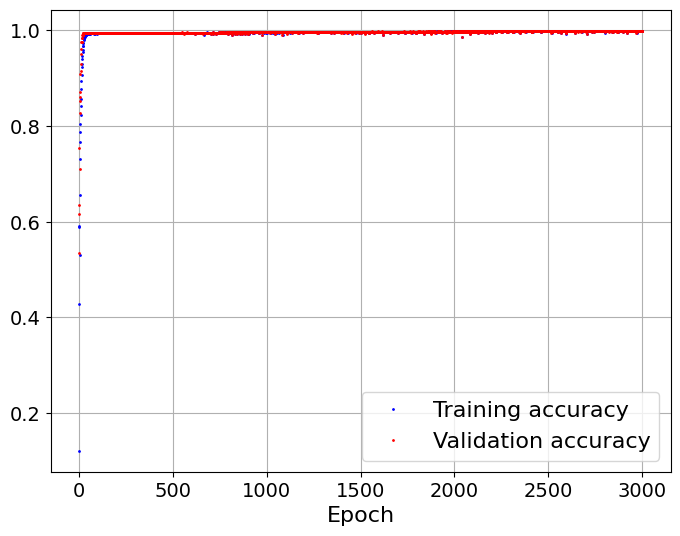

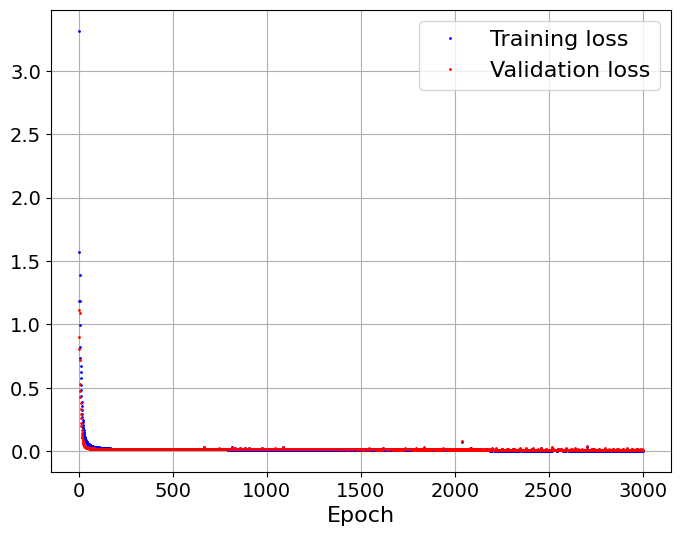

In [33]:
# Here we print the loss and accuracy
epochs = range(1, len(train_acc) + 1)
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_acc, "b.", markersize=2, label="Training accuracy")
plt.plot(epochs, val_acc, "r.", markersize=2, label="Validation accuracy")
# plt.title("Training and validation accuracy",fontsize=16)
plt.xlabel('Epoch',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.legend(fontsize=16)
plt.savefig('accuracy_1.png',dpi=300)
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(epochs, train_loss, "b.", markersize=2, label="Training loss")
plt.plot(epochs, val_loss, "r.", markersize=2, label="Validation loss")
# plt.title("Training and validation loss",fontsize=16)
plt.xlabel('Epoch',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.legend(fontsize=16)
plt.savefig('loss_1.png',dpi=300)
plt.show()

### Accuracy with the validation set

In [34]:
proteinA = u_test.select_atoms('resid 1:108')
ramaA = dihedrals.Ramachandran(proteinA).run()
trj_phipsiA = ramaA.results.angles
_,basinsA,_ = phipsi_to_basin(trj_phipsiA,phi_shift=-120.,
                                     cluster=False,
                                     n_clusters=4,
                                     plot=False)
        
proteinB = u_test.select_atoms('resid 109:197')
ramaB = dihedrals.Ramachandran(proteinB).run()
trj_phipsiB = ramaB.results.angles
_,basinsB,_ = phipsi_to_basin(trj_phipsiB,phi_shift=-120.,
                                     cluster=False,
                                     n_clusters=4,
                                     plot=False)

test_input1,test_input2,test_target,test_dataset = dataset_from_basin_trj(basinsA,basinsB,
                                               reduce=True,
                                               reduce_cycles=0,
                                               skip_frames=3,
                                               batch_size='All',
                                               n_cpu=2,
                                               n_fetch=1)  

test_input1.shape,test_input2.shape,test_target.shape,test_dataset

(334, 107) (334, 88)


((334, 198),
 (334, 198),
 (334, 198),
 <PrefetchDataset element_spec=({'train1': TensorSpec(shape=(None, 198), dtype=tf.int32, name=None), 'train2': TensorSpec(shape=(None, 198), dtype=tf.int32, name=None)}, TensorSpec(shape=(None, 198), dtype=tf.int32, name=None))>)

In [35]:
### Saving the model
model_save_path = 'Transformer_v8.45_model'
transformer.save_weights('Transformer_v8.45_weights.h5', overwrite=True, save_format='h5', options=None)

tf.saved_model.save(transformer,model_save_path )
#tf.saved_model.load(model_save_path)

INFO:tensorflow:Assets written to: Transformer_v8.45_model/assets


INFO:tensorflow:Assets written to: Transformer_v8.45_model/assets


In [36]:
transformer.summary()

transformer.load_weights('Transformer_v8.45_weights.h5')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 train1 (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 train2 (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 EncoderEmbedding (PosEmbedding  (None, 198, 32)     7296        ['train1[0][0]']                 
 )                                                                                                
                                                                                                  
 DecoderEmbedding (PosEmbedding  (None, 198, 32)     7296        ['train2[0][0]']             

In [37]:
print(f"Validation acc: {transformer.evaluate(val_dataset)[1]:.3f}")
print(f"Validation acc: {transformer.evaluate(test_dataset)[1]:.3f}")

aa = transformer.get_layer(name=None, index=4).get_weights()

for i in aa:
    print(i.shape)
#print(aa[6])

1/1 [==============================] - 0s 90ms/step - loss: 0.0105 - accuracy: 0.9985
Validation acc: 0.998
1/1 [==============================] - 0s 66ms/step - loss: 0.0305 - accuracy: 0.9968
Validation acc: 0.997
(32, 4, 32)
(4, 32)
(32, 4, 32)
(4, 32)
(32, 4, 32)
(4, 32)
(4, 32, 32)
(32,)
(32, 64)
(64,)
(64, 32)
(32,)
(32,)
(32,)
(32,)
(32,)


----- activations -----
(500, 198, 32)
attention = 6336
(4, 198, 198)
[[0.00723009 0.00723009 0.00723009 ... 0.00723009 0.00723009 0.00723009]
 [0.14671366 0.14671366 0.14671366 ... 0.14671366 0.14671366 0.14671366]
 [0.04810933 0.04810933 0.04810933 ... 0.04810933 0.04810933 0.04810933]
 ...
 [0.02558466 0.02558466 0.02558466 ... 0.02558466 0.02558466 0.02558466]
 [0.02412861 0.02412861 0.02412861 ... 0.02412861 0.02412861 0.02412861]
 [0.0323393  0.0323393  0.0323393  ... 0.0323393  0.0323393  0.0323393 ]] [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
tf.Tensor(
[[0.7098462  0.7080981  0.7099476  ... 0.         0.         0.        ]
 [0.02097287 0.01916642 0.01939023 ... 0.         0.         0.        ]
 [0.09574178 0.09223273 0.09291575 ... 0.         0.         0.        ]
 ...
 [0.19441128 0.18759055 0.18835865 ... 0.         0.         0.        ]
 [0.20692767 0.2002733

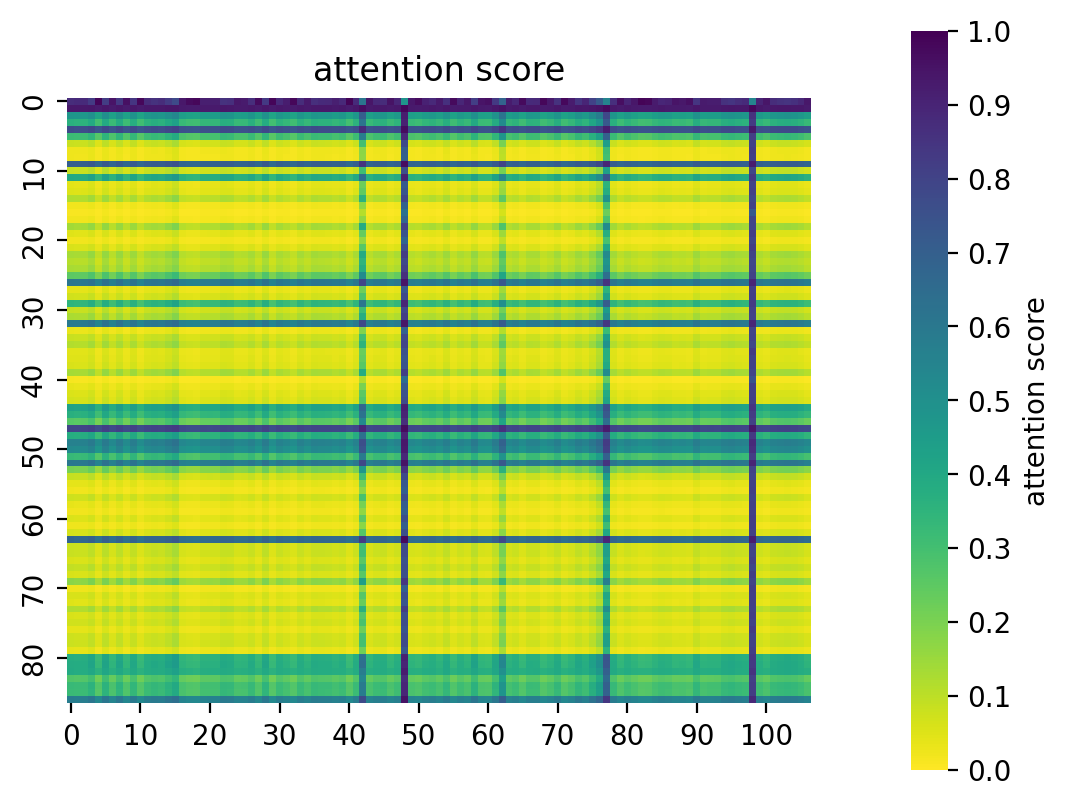

In [38]:
import keras.backend as K
def get_activations(model, inputs, print_shape_only=False, layer_name=None):
    # Documentation is available online on Github at the address below.
    # From: https://github.com/philipperemy/keras-visualize-activations
    print('----- activations -----')
    activations = []
    inp = model.input
    if layer_name is None:
        outputs = [layer.output for layer in model.layers]
    else:
        outputs = [layer.output for layer in model.layers if layer.name == layer_name]  # all layer outputs
    funcs = [K.function([inp], [out]) for out in outputs]  # evaluation functions
    layer_outputs = [func([inputs, 1.])[0] for func in funcs]
    for layer_activations in layer_outputs:
        activations.append(layer_activations)
        if print_shape_only:
            print(layer_activations.shape)
        else:
            print(layer_activations)
    return activations


testing_inputs_1 = list(val_dataset) #val_dataset
#testing_inputs_1 = [test_input1,test_input2]
attention_vector = get_activations(transformer, testing_inputs_1,
                                       print_shape_only=True,
                                       layer_name='Encoder')[0][0].flatten()
print('attention =', len(attention_vector))

mat_cc,mat_dd = transformer.get_layer(index=4).get_attention_scores()

a = tf.reduce_mean(mat_cc, 0)
print(a.shape)
a = tf.reduce_mean(a, 0)

def norm(data):
    data_max, data_min = np.tile(np.max(data, axis=-1)[:, np.newaxis], [1, data.shape[1]]), np.tile(np.min(data, axis=-1)[:, np.newaxis], [1, data.shape[1]])
    data_norm = (data - data_min) / (data_max - data_min)
    print(data_max , data_min)
    return data_norm

#a= tf.math.l2_normalize(a,1)
a = norm(a)
print(a)

import matplotlib.pyplot as plt
import seaborn as sns

print(len(sequence_as_A),len(sequence_as_B[:-1]))
plt.figure(dpi=200)
ax = sns.heatmap(a[108:195,:107], vmin = 0, vmax = 1, cmap = 'viridis_r', square=True, xticklabels=10, yticklabels=10,cbar=True,
                            cbar_kws={'label': 'attention score', 
                           'orientation': 'vertical',
                           "ticks":np.arange(0,1.1,0.1),
                           "format":"%.1f",
                           "pad":0.1,
                                                   }
                )

#ax.set_xlabel(sequence_as_A)
#ax.set_ylabel(sequence_as_B[:-1])
plt.title("attention score")
plt.savefig('attention_score45.png',dpi=300)
print('shape',a[108:195,:107].shape)

#### Preparing a generic basin frame for prediction

In [40]:
# Function to recursively predict the next position in the frame sequence from
# the previous ones already calculated

def predict_frame(input_sequence,model,mdsl,pad,startpad,endpad):
    decoded_sequence = (np.ones((mdsl,))*pad).astype('int32')
    decoded_sequence[0] = startpad
    decoded_sequence = np.expand_dims(decoded_sequence,axis=0)    
    end = np.array([endpad]).astype('int32')
    for i in range(mdsl):
        input_sequence_2 = [input_sequence,decoded_sequence] 
        prediction = model(input_sequence_2)
        sampled_token = np.argmax(prediction[0, i, :])
        if i+1 > mdsl:
            break
        decoded_sequence[:,i+1] = sampled_token
        if sampled_token == end:
            break            
     
    return decoded_sequence

### Trajectory extension

Rapid convergence on a sequence that remains unchanged in the following extension cycles is avoided by introducing entropy in the prediction. In this case, instead of taking the peak of the probability distribution for the next predicted basin symbol, we accept a lower than maximum value. The higher the temperature we select in the 'sample_next' function, the higher the entropy of the prediction, so that lower than maximum values of the probability distribution of the 4 symbols are taken. 

In [41]:
def sample_next(predictions, temperature=1.0):
    predictions = np.asarray(predictions).astype("float64")
    predictions = np.log(predictions) / temperature
    exp_preds = np.exp(predictions)
    predictions = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, predictions, 1)
    return probas

def predict_frame_with_entropy(input_sequence,
                               model,mdsl,
                               pad,startpad,
                               endpad,
                               temperature):
    
    # global variables declared for debugging purpose
    # global decoded_sequence, sampled_token
    
    decoded_sequence = (np.ones((mdsl,))*pad).astype('int32')
    decoded_sequence[0] = startpad
    decoded_sequence = np.expand_dims(decoded_sequence,axis=0)    
    end = np.array([endpad]).astype('int32')
    for i in range(mdsl):
        input_sequence_2 = [input_sequence,decoded_sequence] 
        prediction = model(input_sequence_2)
        next_token = sample_next(prediction[0, i, :],temperature)
        sampled_token = np.argmax(next_token)
        # if i+1 > mdsl:
        if i+1 == mdsl:
            break        
        decoded_sequence[:,i+1] = sampled_token
        if sampled_token == end:
            break            

    return decoded_sequence    

#### Trajectory extension from an initial  frame of basins

We choose a frame from the validation trajectory of basins. 

In [44]:
input_basin_frame_number = 96

print(test_input1.shape,test_input2.shape,test_target.shape,test_dataset)

input_frame = test_input1[input_basin_frame_number]
print(input_frame.shape)
print(*input_frame)

(334, 198) (334, 198) (334, 198) <PrefetchDataset element_spec=({'train1': TensorSpec(shape=(None, 198), dtype=tf.int32, name=None), 'train2': TensorSpec(shape=(None, 198), dtype=tf.int32, name=None)}, TensorSpec(shape=(None, 198), dtype=tf.int32, name=None))>
(198,)
0 1 0 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 1 1 0 0 0 1 1 1 1 1 1 1 2 0 0 1 1 1 2 1 1 1 1 1 0 0 2 0 0 0 3 2 0 0 0 1 2 1 1 2 1 0 0 0 0 0 2 0 0 0 0 0 0 0 0 2 0 1 0 3 0 0 0 1 0 0 0 0 0 0 1 1 2 0 0 0 0 0 1 1 3 2 1 0 0 0 0 1 1 4 3 0 0 0 0 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 2 0 0 1 1 0 1 2 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 2 1 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 0 1 0 0 0 0 7 7 7


In [45]:
# Here we extend the trajectory from the input frame. 
extended_trj_basins_transformer = []
n_extensions = 100 
temperature = 1.5 # default = 1.5

mdsl = 198 # max_decoded_sequence_length
pad = 7
startpad = 5
endpad = 6

# We need to expand the dimensions so that the input appears to the network as a batch
# input_frame = val_inputs1[input_frame_number]
input_frame = np.expand_dims(input_frame,axis=0)

cycle = 1
frame_number = 1
while cycle <= n_extensions:

# Predict next frame and strip all padding
    next_frame = predict_frame_with_entropy(input_frame,
                                        transformer,
                                        mdsl,
                                        pad,
                                        startpad,
                                        endpad,
                                        temperature)
    next_frame = np.squeeze(next_frame)
    next_frame = next_frame[1:-2].astype('int32')

    extended_trj_basins_transformer.append(next_frame)

# Strip new_input padding 
    input_frame = np.squeeze(input_frame)
    input_frame = input_frame[:-3]    

    #print(f'Input frame {frame_number} {input_frame.shape}:')
    #print(*input_frame)
    #print(f'Predicted frame {next_frame.shape}:')
    #print(*next_frame)    

# Identify different positions between input and predicted frame
    diff_ind = input_frame!=next_frame    
    diff_ind_pos = np.where(diff_ind)[0]    
    next_frame_marked = np.copy(next_frame) 
    next_frame_marked[diff_ind] = 8

    #print(f'Predicted frame marked for differences at positions: ', [*diff_ind_pos])
    #print(*next_frame_marked,'\n')    

# The predicted frame becomes the new input
    next_frame = np.concatenate((next_frame,[7,7,7]),axis=0)
    next_frame = np.expand_dims(next_frame,axis=0)
    input_frame = next_frame

# Check for frames having low probability basin or termination symbols (s>3). 
# If this occurs, update only the frame number    
    if np.max(next_frame[0][:-3]) > 4:        
        print(f'Extension error at frame {frame_number}')
        frame_number += 1
    else:
        frame_number += 1
        cycle += 1

In [46]:
valid_i = 1
for i in range(len(extended_trj_basins_transformer)):
    if np.max(extended_trj_basins_transformer[i]) > 4:
        continue

    #print(f'Predicted Frame {valid_i} :')
    #print(*extended_trj_basins_transformer[i])
    valid_i += 1


extended_trj_phipsi_from_basins = []
for i,frame in enumerate(extended_trj_basins_transformer):
    frame = np.squeeze(frame)
    if np.max(frame)>4:
        continue
    single_frame_phi_psi = []
    for j,basin in enumerate(frame):
        if basin==4:
            #print(i,j,basin)
            #print(*frame[:j],':',*frame[j+1:])
            break

In [47]:
# Convert basin trajectory into angle trajectory using centroids
extended_trj_phipsi_from_basins_A = []
for i,frame in enumerate(extended_trj_basins_transformer):
    frame = np.squeeze(frame)
    if np.max(frame)>4:
        continue
    single_frame_phi_psi_A = []
    for j,basin in enumerate(frame):
        if basin==4:
            #print(i,j,basin)
            #print(*frame[:j],':',*frame[j+1:])
            break
        
    
        phi_psi_A = val_centroids[basin]
        single_frame_phi_psi_A.append(phi_psi_A.tolist())
        single_frame_phi_psi_ndarray_A = np.array(single_frame_phi_psi_A)
    extended_trj_phipsi_from_basins_A.append(single_frame_phi_psi_ndarray_A)

extended_trj_phipsi_from_basins_A = np.array(extended_trj_phipsi_from_basins_A)

#print(extended_trj_phipsi_from_basins_A.shape)
#print(extended_trj_phipsi_from_basins_A[0])

# Convert degrees to radians
deg_to_rad = np.pi/180.
extended_trj_phipsi_A = extended_trj_phipsi_from_basins_A * deg_to_rad


# Convert basin trajectory into angle trajectory using centroids
extended_trj_phipsi_from_basins_B = []
for i,frame in enumerate(extended_trj_basins_transformer):
    frame = np.squeeze(frame)
    if np.max(frame)>4:
        continue
    single_frame_phi_psi_B = []
    mark =0
    for j,basin in enumerate(frame):
        if basin==4:
            #print(i,j,basin)
            #print(*frame[:j],':',*frame[j+1:])
            mark=1
            continue
        
        if mark ==1:   
            phi_psi_B = val_centroids[basin]
            single_frame_phi_psi_B.append(phi_psi_B.tolist())
            single_frame_phi_psi_ndarray_B = np.array(single_frame_phi_psi_B)
    extended_trj_phipsi_from_basins_B.append(single_frame_phi_psi_ndarray_B)

extended_trj_phipsi_from_basins_B = np.array(extended_trj_phipsi_from_basins_B)

print(extended_trj_phipsi_from_basins_B.shape)
print(extended_trj_phipsi_from_basins_B[0])

# Convert degrees to radians
deg_to_rad = np.pi/180.
extended_trj_phipsi_B = extended_trj_phipsi_from_basins_B * deg_to_rad

# Here we check the reshaping was correct
print(extended_trj_phipsi_B.shape)
print(extended_trj_phipsi_B[0])

# Conversion of the extended trajectory frame to Modeller format
# This conversion requires substituting with MDAnalysis all the CD atoms of ILE to CD1 and the O1,O2 atoms of the last residue to O and OXT.
# Check that Modeller correctly implements dihedral restraints

(100, 88, 2)
[[  74.92655423  150.86497936]
 [-102.59127078  131.92978561]
 [-102.59127078  131.92978561]
 ...
 [-102.59127078  131.92978561]
 [-102.59127078  131.92978561]
 [-102.59127078  131.92978561]]
(100, 88, 2)
[[ 1.30771507  2.63309062]
 [-1.79055546  2.30260914]
 [-1.79055546  2.30260914]
 ...
 [-1.79055546  2.30260914]
 [-1.79055546  2.30260914]
 [-1.79055546  2.30260914]]


In [48]:
# Convert the basins of the the validation frame selected to start 
# extension into phi-psi angles in radians 

u_val_0_basins = val_basins_A[input_basin_frame_number]
#print(*u_val_0_basins,len(u_val_0_basins))

u_val_0_phipsi_radians_A = []
for basin in u_val_0_basins:
    phi_psi = val_centroids[basin]*deg_to_rad
    u_val_0_phipsi_radians_A.append(phi_psi.tolist())
u_val_0_phipsi_radians_A = np.array(u_val_0_phipsi_radians_A)


# In[62]:


# Convert the basins of the the validation frame selected to start 
# extension into phi-psi angles in radians 

u_val_0_basins = val_basins_B[input_basin_frame_number]
#print(*u_val_0_basins,len(u_val_0_basins))

u_val_0_phipsi_radians_B = []
for basin in u_val_0_basins:
    phi_psi = val_centroids[basin]*deg_to_rad
    u_val_0_phipsi_radians_B.append(phi_psi.tolist())
u_val_0_phipsi_radians_B = np.array(u_val_0_phipsi_radians_B)


print(*u_val_0_phipsi_radians_A[:10],len(u_val_0_phipsi_radians_A))
print(*u_val_0_phipsi_radians_B[:10],len(u_val_0_phipsi_radians_B))

[-1.79055546  2.30260914] [-1.26551761 -0.54330947] [-1.79055546  2.30260914] [-1.26551761 -0.54330947] [-1.26551761 -0.54330947] [-1.26551761 -0.54330947] [-1.26551761 -0.54330947] [-1.26551761 -0.54330947] [-1.26551761 -0.54330947] [-1.26551761 -0.54330947] 107
[1.30771507 2.63309062] [-1.79055546  2.30260914] [-1.79055546  2.30260914] [-1.79055546  2.30260914] [-1.79055546  2.30260914] [-1.79055546  2.30260914] [-1.26551761 -0.54330947] [-1.26551761 -0.54330947] [-1.26551761 -0.54330947] [-1.79055546  2.30260914] 88


In [51]:
#input_protein_frame_number = 48
#input_protein_frame_number = 11
input_protein_frame_number = 10

u_val.trajectory[input_protein_frame_number]
u_val_0_protein_A = u_val.select_atoms('resid 1:108 and not (name H* )')

#proteinB = u_test.select_atoms('resid 86:98')

with mda.Writer("ua_val_A.pdb",bonds='all',
            n_atoms=None,
            convert_units=True,
            reindex=True) as pdb:
    pdb.write(u_val_0_protein_A) 

u_val_0_protein_A = mda.Universe('ua_val_A.pdb','ua_val_A.pdb')

u_val_0_protein_A = u_val_0_protein_A.select_atoms('resid 1:108 and not (name H* )')

# Change chainid to 'A'
for atom_ind in range(len(u_val_0_protein_A)): 
    u_val_0_protein_A.atoms[atom_ind].chainID = 'A'

n_res_A = len(u_val_0_protein_A.residues)

# If necessary, we shift all atoms into the unit cell
# u_val_0_protein.pack_into_box(box=None, inplace=True)

# Change HSD to HIS
HSD_ATOMS = u_val_0_protein_A.select_atoms('resname HIE') #HSD
for atom_ind in range(len(HSD_ATOMS)):
    HSD_ATOMS.atoms[atom_ind].residue.resname ='HIS' # 'HIE'

# Change Isoleucine CD to CD1
#    ILE_CD_ATOMS = u_val_0_protein_A.select_atoms('resname ILE and (name CD)')
#    for atom_ind in range(len(ILE_CD_ATOMS)):
#        ILE_CD_ATOMS.atoms[atom_ind].name = 'CD1'

# Change CTERM atoms O1,O2 to O and OXT
lastresnum = 'resnum ' + str(len(u_val_0_protein_A.residues))
CTERM_ATOMS = u_val_0_protein_A.select_atoms(lastresnum)
CTERM_ATOMS[-2].name = 'O'
CTERM_ATOMS[-1].name = 'OXT'

with mda.Writer("ua_val_0_A_ori.pdb",bonds='all',
            n_atoms=None,
            convert_units=True,
            reindex=True) as pdb:
    pdb.write(u_val_0_protein_A)    


# using MDAnalysis write out without hydrogens the input frame 
# from the 'protein' validation trajectory 

#input_protein_frame_number = 48
input_protein_frame_number = 10

u_val.trajectory[input_protein_frame_number]
u_val_0_protein_B = u_val.select_atoms('resid 109:197 and not (name H* )')

with mda.Writer("ub_val_B.pdb",bonds='all',
            n_atoms=None,
            convert_units=True,
            reindex=True) as pdb:
    pdb.write(u_val_0_protein_B) 

# Change chainid to 'B'
for atom_ind in range(len(u_val_0_protein_B)): 
    u_val_0_protein_B.atoms[atom_ind].chainID = 'B'

n_res_B = len(u_val_0_protein_B.residues)

# If necessary, we shift all atoms into the unit cell
# u_val_0_protein.pack_into_box(box=None, inplace=True)

# Change HSD to HIS
HSD_ATOMS = u_val_0_protein_B.select_atoms('resname HIE') #HSD
for atom_ind in range(len(HSD_ATOMS)):
    HSD_ATOMS.atoms[atom_ind].residue.resname = 'HIS'#'HIE'

# Change Isoleucine CD to CD1
#    ILE_CD_ATOMS = u_val_0_protein_B.select_atoms('resname ILE and (name CD)')
#    for atom_ind in range(len(ILE_CD_ATOMS)):
#        ILE_CD_ATOMS.atoms[atom_ind].name = 'CD1'

# Change CTERM atoms O1,O2 to O and OXT
    #lastresnum = 'resnum ' + str(len(u_val_0_protein_B.residues))
    #CTERM_ATOMS = u_val_0_protein_B.select_atoms(lastresnum)
#CTERM_ATOMS[-2].name = 'O'
#CTERM_ATOMS[-1].name = 'OXT'

for atom_ind in range(len(u_val_0_protein_B)): 
    u_val_0_protein_B.atoms[atom_ind].chainID = 'B'  



with mda.Writer("ub_val_0_B.pdb",bonds='all',
            n_atoms=None,
            convert_units=True,
            reindex=True) as pdb:
    pdb.write(u_val_0_protein_B)    


# After converting HSD to HIS, write out again the sequence in 1 letter code

# Protein sequence in 3 letter code
prot_sequence_tlc = ''
for res in chain.from_iterable(u_val_0_protein_A.residues.resnames):
    prot_sequence_tlc += res
# print(f'Protein sequence in 3 letter code:\n{prot_sequence_tlc}\n')

# Protein sequence as separated 3 letter code 
split_prot_sequence_tlc = []
n = 3
for index in range(0, len(prot_sequence_tlc), n):
    split_prot_sequence_tlc.append(prot_sequence_tlc[index : index + n])
# print(f'Protein sequence in split 3 letter code:\n{split_prot_sequence_tlc}\n')

# Protein sequence in 3 letter code
prot_sequence_slc_A = seq1(prot_sequence_tlc)
print(f'Protein sequence in 1 letter code:\n{prot_sequence_slc_A}',len(prot_sequence_slc_A))


# After converting HSD to HIS, write out again the sequence in 1 letter code

# Protein sequence in 3 letter code
prot_sequence_tlc = ''
for res in chain.from_iterable(u_val_0_protein_B.residues.resnames):
    prot_sequence_tlc += res
# print(f'Protein sequence in 3 letter code:\n{prot_sequence_tlc}\n')

# Protein sequence as separated 3 letter code 
split_prot_sequence_tlc = []
n = 3
for index in range(0, len(prot_sequence_tlc), n):
    split_prot_sequence_tlc.append(prot_sequence_tlc[index : index + n])
# print(f'Protein sequence in split 3 letter code:\n{split_prot_sequence_tlc}\n')

# Protein sequence in 3 letter code
prot_sequence_slc_B = seq1(prot_sequence_tlc)
print(f'Protein sequence in 1 letter code:\n{prot_sequence_slc_B}',len(prot_sequence_slc_B))

Protein sequence in 1 letter code:
VINTFDGVADYLQTYHKLPDNYITKSEAQALGWVASKGNLADVAPGKSIGGDIFSNREGKLPGKSGRTWREADINYTSGFRNSDRILYSSDWLIYKTTDHYQTFTKIR 108
Protein sequence in 1 letter code:
KKAVINGEQIRSISDLHQTLKKELALPEYYGENLDALWDALTGWVEYPLVLEWRQFEQSKQLTENGAESVLQVFREAKAEGADITIILS 89


In [53]:
# #### Modeller environment

# Initial alignment

sequence = prot_sequence_slc_A + '*'

with open("alignment_A.ali", "w") as text_file:
    print(f'>P1;orig\nstructureX:ua_val_0_A.pdb:1:A:{n_res_A}:A::::\n{sequence}',file=text_file)
    print(f'>P1;seq\nsequence::1:A:{n_res_A}:A::::\n{sequence}',file=text_file)


# Initial alignment

sequence = prot_sequence_slc_B + '*'

with open("alignment_B.ali", "w") as text_file:
    print(f'>P1;orig\nstructureX:ub_val_0_B.pdb:1:B:{n_res_B}:B::::\n{sequence}',file=text_file)
    print(f'>P1;seq\nsequence::1:B:{n_res_B}:B::::\n{sequence}',file=text_file)    


print('u_val_0_phipsi_radians_A:',u_val_0_phipsi_radians_A,len(u_val_0_phipsi_radians_A),u_val_0_phipsi_radians_A.shape)
print('u_val_0_phipsi_radians_B:',u_val_0_phipsi_radians_B,len(u_val_0_phipsi_radians_B),u_val_0_phipsi_radians_B.shape)


# Initial minimization of the reference structure with phi-psi constraints

log.level(output=0, notes=0, warnings=0, errors=0, memory=0)
env = Environ()
env.io.atom_files_directory = '.'
env.edat.dynamic_sphere = True

env.libs.topology.read(file='$(LIB)/top_heav.lib')
env.libs.parameters.read(file='$(LIB)/par.lib')

code = 'ua_val_0_A'
mdl = complete_pdb(env, code + '.pdb')
mdl.write(file = code + '.pdb')

rsr = mdl.restraints

# Select all atoms:
atmsel = Selection(mdl)    

atmsel.assess_dope(output='ENERGY_PROFILE NO_REPORT', file='TvLDH.profile',
          normalize_profile=True, smoothing_window=15)

# Generate the static restraints:
rsr.make(atmsel, restraint_type='stereo', spline_on_site=False)

# Example of atoms selection for phi-psi restraints
# 2 ARG PHI:  (1 MET C)-(2 ARG N)-(2 ARG CA)-(2 ARG C)  
# 2 ARG PSI:  (2 ARG N)-(2 ARG CA)-(2 ARG C)-(3 ILE N) 

# Add dynamic restraints on the phi-psi dihedrals
for i in range(2,108): 
    phi_1 = mdl.atoms['C:'+str(i-1)+':A']
    phi_2 = mdl.atoms['N:'+str(i)+':A']
    phi_3 = mdl.atoms['CA:'+str(i)+':A']
    phi_4 = mdl.atoms['C:'+str(i)+':A']    
    psi_1 = mdl.atoms['N:'+str(i)+':A']
    psi_2 = mdl.atoms['CA:'+str(i)+':A']
    psi_3 = mdl.atoms['C:'+str(i)+':A']
    psi_4 = mdl.atoms['N:'+str(i+1)+':A']

# Binormal constraints
    rsr.add(forms.MultiBinormal(group=physical.phi_psi_dihedral,
                       features=[features.Dihedral(phi_1, phi_2, phi_3, phi_4),
                                 features.Dihedral(psi_1, psi_2, psi_3, psi_4)],
                       weights=[100,100],
                       means=[u_val_0_phipsi_radians_A[i-2,:].tolist(),                                
                              u_val_0_phipsi_radians_A[i-2,:].tolist()],                                
                       stdevs=[[0.1,0.1],[0.1,0.1]],
                       correls=[0.5,0.5]))    

mdl.restraints.write(file = code + '.rsr')

# Addition of restraints to the default ones
class RestrainModel(AutoModel):
    def special_restraints(self, aln):
        rsr = self.restraints
    # Add restraints from file:
        rsr.append(file = code + '.rsr')          

a = RestrainModel(env,
        alnfile  = 'alignment_A.ali',     # alignment filename
        knowns   = 'orig',              # codes of the templates
        sequence = 'seq',
        )              # code of the target
a.starting_model= 1                 # index of the first model
a.ending_model  = 1                 # index of the last model
                                # (determines how many models to calculate)
a.make()                            # do comparative modeling

a.write(file='ua_val_0_min_A.pdb')
print(a)


# Initial minimization of the reference structure with phi-psi constraints

log.level(output=0, notes=0, warnings=0, errors=0, memory=0)
env = Environ()
env.io.atom_files_directory = '.'
env.edat.dynamic_sphere = True

env.libs.topology.read(file='$(LIB)/top_heav.lib')
env.libs.parameters.read(file='$(LIB)/par.lib')

code = 'ub_val_0_B' 
mdl = complete_pdb(env, code + '.pdb')
mdl.write(file = code + '.pdb')
rsr = mdl.restraints

# Select all atoms:
atmsel = Selection(mdl)    

atmsel.assess_dope(output='ENERGY_PROFILE NO_REPORT', file='TvLDH.profile',
          normalize_profile=True, smoothing_window=15)

# Generate the static restraints:
rsr.make(atmsel, restraint_type='stereo', spline_on_site=False)

# Example of atoms selection for phi-psi restraints
# 2 ARG PHI:  (1 MET C)-(2 ARG N)-(2 ARG CA)-(2 ARG C)  
# 2 ARG PSI:  (2 ARG N)-(2 ARG CA)-(2 ARG C)-(3 ILE N) 

# Add dynamic restraints on the phi-psi dihedrals
for i in range(2,89): 
    phi_1 = mdl.atoms['CA:'+str(i-1)+':B']
    phi_2 = mdl.atoms['N:'+str(i)+':B']
    phi_3 = mdl.atoms['CA:'+str(i)+':B']
    phi_4 = mdl.atoms['C:'+str(i)+':B']    
    psi_1 = mdl.atoms['N:'+str(i)+':B']
    psi_2 = mdl.atoms['CA:'+str(i)+':B']
    psi_3 = mdl.atoms['C:'+str(i)+':B']
    psi_4 = mdl.atoms['N:'+str(i+1)+':B']

# Binormal constraints
    rsr.add(forms.MultiBinormal(group=physical.phi_psi_dihedral,
                       features=[features.Dihedral(phi_1, phi_2, phi_3, phi_4),
                                 features.Dihedral(psi_1, psi_2, psi_3, psi_4)],
                       weights=[100,100],
                       means=[u_val_0_phipsi_radians_B[i-2,:].tolist(),                                
                              u_val_0_phipsi_radians_B[i-2,:].tolist()],                                
                       stdevs=[[0.1,0.1],[0.1,0.1]],
                       correls=[0.5,0.5]))    

mdl.restraints.write(file = code + '.rsr')

# Addition of restraints to the default ones
class RestrainModel(AutoModel):
    def special_restraints(self, aln):
        rsr = self.restraints
    # Add restraints from file:
        rsr.append(file = code + '.rsr')          

a = RestrainModel(env,
        alnfile  = 'alignment_B.ali',     # alignment filename
        knowns   = 'orig',              # codes of the templates
        sequence = 'seq',
        )              # code of the target
a.starting_model= 1                 # index of the first model
a.ending_model  = 1                 # index of the last model
                                # (determines how many models to calculate)
a.make()                            # do comparative modeling

a.write(file='ub_val_0_min_B.pdb')

code = 'ub_val_0_min_B'

protein_B = mda.Universe(code + '.pdb',code + '.pdb')
protein_B = protein_B.select_atoms('resid 1:89')

for atom_ind in range(len(protein_B)): 
    protein_B.atoms[atom_ind].chainID = 'B'


with mda.Writer(code + '.pdb',bonds='all',n_atoms=None,convert_units=True,reindex=True) as pdb:
    pdb.write(protein_B) 

u_val_0_phipsi_radians_A: [[-1.79055546  2.30260914]
 [-1.26551761 -0.54330947]
 [-1.79055546  2.30260914]
 ...
 [-1.79055546  2.30260914]
 [-1.26551761 -0.54330947]
 [-1.26551761 -0.54330947]] 107 (107, 2)
u_val_0_phipsi_radians_B: [[ 1.30771507  2.63309062]
 [-1.79055546  2.30260914]
 [-1.79055546  2.30260914]
 ...
 [-1.79055546  2.30260914]
 [-1.79055546  2.30260914]
 [-1.79055546  2.30260914]] 88 (88, 2)
>> Model assessment by DOPE potential
DOPE score               : -10478.361328
0 atoms in HETATM/BLK residues constrained
to protein atoms within 2.30 angstroms
and protein CA atoms within 10.00 angstroms
0 atoms in residues without defined topology
constrained to be rigid bodies

>> Summary of successfully produced models:
Filename                          molpdf
----------------------------------------
seq.B99990001.pdb             1572.72717

<Model containing 1 chain, 108 residues, and 864 atoms>
>> Model assessment by DOPE potential
DOPE score               : -9979.946289
0 at

In [56]:
def merge_pdb_files(input_file1, input_file2, output_file):
    with open(input_file1, 'r') as file1:
        lines1 = file1.readlines()

    with open(input_file2, 'r') as file2:
        lines2 = file2.readlines()

# Extract ATOM and HETATM records from both files
    atom_lines1 = [line for line in lines1 if line.startswith("ATOM") or line.startswith("HETATM")]
    atom_lines2 = [line for line in lines2 if line.startswith("ATOM") or line.startswith("HETATM")]

# Combine the ATOM and HETATM records
    combined_lines = atom_lines1 + atom_lines2

# Write the combined PDB data to the output file
    with open(output_file, 'w') as output:
        output.writelines(combined_lines)

merge_pdb_files("ua_val_0_A.pdb", "ub_val_0_min_B.pdb", "./gen/gen_merged_"+str(input_basin_frame_number)+".pdb")
merge_pdb_files("ua_val_0_A.pdb", "ub_val_0_B.pdb", "./gen/ori_merged_"+str(input_basin_frame_number)+".pdb") 